In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import re
import spacy
import random
import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from fancyimpute import IterativeImputer
import emoji

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Reading file


In [ ]:
df_pri = pd.read_csv('/content/drive/MyDrive/vlsp2020/final_private_test_dropped_no_label.csv')
print(df_pri.info())
display(df_pri.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1030 non-null   float64
 5   num_comment_post  969 non-null    object 
 6   num_share_post    904 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 90.1+ KB
None


,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post
0,6015,fbf39587d668e9ae28afb00b8fc00570,Các lời khai cố tình bị rút ra để áp án tử cho...,1.590163e+09,NaN,NaN,NaN
1,6016,c4acc2118bdcdb5770565362b02d00e0,(NLĐO) – Lực lượng cứu hoả gần như phải thức t...,1.586500e+09,4.0,NaN,NaN
2,6017,180dd4930112053803ccea8556f33e47,Cư dân mạng đang tranh cãi sôi nổi sau quyết đ...,1.592102e+09,963.0,50,6
3,6018,ac4d365f23909091fab2552bdc54f5ef,3 công nhân trung quốc làm cty hòa phát bị nhi...,1.596256e+09,NaN,NaN,NaN
4,6019,5ba5638b734e397d5263a6b1b9201abd,Một số người p Tây nhìn người Á hay Phi ko thi...,1.587462e+09,5.0,3,NaN


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/vlsp2020/public_train.csv')
df_test = pd.read_csv('/content/drive/My Drive/vlsp2020/public_test.csv')
print(df_train.info())
print(df_test.info())
display(df_train.head())
display(df_test.head())

In [ ]:
df_train[df_train['post_message'].isnull()==True]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
2247,2248,66a74969be46766c182b99dc01740a11,NaN,1585331222,9717,28,88.0,0


In [ ]:
df_train.drop(index=2247,inplace=True)
df_train.reset_index(inplace=True)

# Preprocessing text

In [ ]:
import emoji

def delete_emoji(text):
    res=""
    # change emoticon to text
    text = re.sub(r'(?:[<>]?[:;=8>][\-o\*\']?[\)\]dDpP]|[\(\[dDpP\{][\-o\*\']?[:;=8<][<>]?|<[/\\]?3|\(?\(?\#?[>\-\^\*\+o\~][\_\.\|\,][<\-\^\*\+o\~][\#\;]?\)?\)?)','vui',text)
    text = re.sub(r'(?:[<>]?[:;=8>][\-o\*\']?[\(\[xX/\\]|[\)\]xX/\}][\-o\*\']?[:;=8<][<>]?|<[/\\]?3|\(?\(?\#?[>\-\^\*\+o\~][\_\.\|\,][<\-\^\*\+o\~][\#\;]?\)?\)?)','buồn',text)
    #text = re.sub(r'(?:[<>]?[:;=8>][\-o\*\']?[\:@\|]|[\:@\|][\-o\*\']?[:;=8<][<>]?|<[/\\]?3|\(?\(?\#?[>\-\^\*\+o\~][\_\.\|\,][<\-\^\*\+o\~][\#\;]?\)?\)?)','',text)
    text = re.sub(r':\(', 'buồn', text)
    text = re.sub(r': \(\(', 'buồn', text)
    text = re.sub(r':, \(', 'buồn', text)
    text = re.sub(r':\)', 'vui', text)
    text = re.sub(r';\)', 'vui', text)
    text = re.sub(r':\)\)\)', 'vui', text)
    text = re.sub(r':\)\)\)\)\)\)', 'vui', text)
    text = re.sub(r'=\)\)\)\)', 'vui', text)

    for i in text:
        if i not in emoji.UNICODE_EMOJI:
            res += i 
    return res

In [ ]:
def preprocess(text):
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'\\u200c', '', text)
  text = re.sub(r'(.)\1{3,}', r'\1\1', text)  #Coooooooool -> Cool

  have_title = 0
  sent = []
  for w in text.split():
    if(w.isupper()):
      have_title += 1
      sent.append(w.lower())
    else:
      sent.append(w)
  text = " ".join(sent)

  text = re.sub(r'(covid-19)|(covid19)|(cv19)|(covid)|(ncov)|(convid)|(covidiot)|(con19)|(cov19)','covid',text) #Change some symnonyms
  text = re.sub(r"\s+", " ", text)

  return text, 1 if have_title > 10 else 0

In [ ]:
preprocess("""Covid-19 covid19 cv19 covid ncov convid covidiot con19 cov19 Ngày 3/4, Đại tướng Tô Lâm, Bộ trưởng Bộ Công an đã ký quyết định số 2398/QĐ-BCA-X01 thăng cấp bậc hàm từ Đại úy lên Thiếu tá đối với đồng chí Đặng Thanh Tuấn.

Cùng ngày, Thiếu tướng Vũ Xuân Viên, Giám đốc CÔNG AN THÀNH PHỐ Đà Nẵng ký Quyết định số 479/QĐ-CATP thăng cấp bậc hàm từ Trung sĩ lên thượng sỹ đối với đồng chí Võ Văn Toàn.

Đây là 2 cán bộ, chiến sỹ đã hy sinh trong quá trình thực hiện nhiệm vụ đảm bảo an ninh, trật tự, phòng, chống tội phạm trên địa bàn thành phố Đà Nẵng.

Trước đó, vào lúc 20h40 ngày 2/4/2020, Công an TP. Đà Nẵng nhận được tin báo của nhân dân có nhóm đối tượng đua xe và cướp giật người đi đường tại khu vực quận Sơn Trà, trong bối cảnh toàn quốc thực hiện cách ly xã hội theo Chỉ thị số 16 của Thủ tướng Chính phủ.

Công an TP. Đà Nẵng đã chỉ đạo cho Công an quận Sơn Trà triển khai lực lượng truy bắt nhóm đối tượng. Trong quá trình truy đuổi các đối tượng trên, Đại úy Đặng Thanh Tuấn và Trung sĩ Võ Văn Toàn bị tai nạn và hy sinh.
----------
Ảnh: TTXVN
""")

('Covid-19 covid covid covid covid covid covidiot covid covid Ngày 3/4 , Đại_tướng Tô_Lâm , Bộ_trưởng Bộ Công_an đã ký quyết_định số 2398 / qđ-bca-x 01 thăng cấp_bậc hàm từ Đại_uý lên Thiếu_tá đối_với đồng_chí Đặng_Thanh_Tuấn . Cùng ngày , Thiếu_tướng Vũ_Xuân_Viên , Giám_đốc công_an thành_phố Đà_Nẵng ký Quyết_định số 479 / qđ-catp thăng cấp_bậc hàm từ Trung_sĩ lên thượng_sỹ đối_với đồng_chí Võ_Văn_Toàn . Đây là 2 cán_bộ , chiến_sỹ đã hy_sinh trong quá_trình thực_hiện nhiệm_vụ đảm_bảo an_ninh , trật_tự , phòng , chống tội_phạm trên địa_bàn thành_phố Đà_Nẵng . Trước đó , vào lúc 20h40 ngày 2/4/2020 , Công_an tp . Đà_Nẵng nhận được tin báo của nhân_dân có nhóm đối_tượng đua xe và cướp_giật người đi đường tại khu_vực quận Sơn_Trà , trong bối_cảnh toàn_quốc thực_hiện cách_ly xã_hội theo Chỉ_thị số 16 của Thủ_tướng Chính_phủ . Công_an tp . Đà_Nẵng đã chỉ_đạo cho Công_an quận Sơn_Trà triển_khai lực_lượng truy bắt nhóm đối_tượng . Trong quá_trình truy_đuổi các đối_tượng trên , Đại_uý Đặng_Than

In [ ]:
import tqdm
train['has_title'] = 0
for i in tqdm.tqdm(range(len(train['post_message']))):
  sent = train['post_message'][i]
  #sent = emoji_cleaning(sent)
  #sent = review_cleaning(sent)
  try:
    sent, title = preprocess(sent)
    train['cleaned_text'][i] = sent
    train['has_title'][i] = title
  except:
    print(sent)

dev['has_title'] = 0
for i in tqdm.tqdm(range(len(dev['post_message']))):
  sent = dev['post_message'][i]
  #sent = emoji_cleaning(sent)
  #sent = review_cleaning(sent)
  try:
    sent, title = preprocess(sent)
    dev['cleaned_text'][i] = sent
    dev['has_title'][i] = title
  except:
    print(sent)

final['has_title'] = 0
for i in tqdm.tqdm(range(len(final['post_message']))):
  sent = final['post_message'][i]
  #sent = emoji_cleaning(sent)
  #sent = review_cleaning(sent)
  try:
    sent, title = preprocess(sent)
    final['cleaned_text'][i] = sent
    final['has_title'][i] = title
  except:
    print(sent)

# Metadata


## Timestamp

Find error in train:

In [ ]:
time = []
for i in range(len(df_pri['timestamp_post'])):
  try:
    df_pri['timestamp_post'][i] = float(df_pri['timestamp_post'][i])
    time.append(df_pri['timestamp_post'][i])
  except:
    print(i,df_pri['timestamp_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
time = []
for i in range(len(df_train['timestamp_post'])):
  try:
    df_train['timestamp_post'][i] = float(df_train['timestamp_post'][i])
    time.append(df_train['timestamp_post'][i])
  except:
    print(i,df_train['timestamp_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


81  Ronaldo lập cột mốc khó tin
591  từ lớp 1 đến lớp 4 tiếp tục đi học từ ngày 4/5 và trẻ em mầm non 5 tuổi đi học trở lại từ ngày 11/5.
1712  Giá vàng thế giới vọt 3% sau khi FED hạ lãi suất
1923  Hà Nội: Nguy hiểm cận kề từ họp chợ tràn ra lòng đường... là những tin nổi bật trong 24h qua.
2591  Nhộn nhịp mùa đánh bắt cá mú đỏ…
3171  Công bố phát hiện bất ngờ về COVID-19 ở Vũ Hán
3489  2 bệnh nhân mắc COVID-19 nặng ở Việt Nam tiến triển tốt
4218  Một hộ dân “sốc” với gần 90 triệu tiền điện tháng 5... là những thông tin được tìm kiếm nhiều nhất trong 24h qua.


In [ ]:
df_train = df_train.drop(df_train.index[[81,591,1712,1923,2591,3171,3489,4218]])
df_train.reset_index(drop=True,inplace=True)

Find error in test:

In [ ]:
for i in range(len(df_test['timestamp_post'])):
  try:
    df_test['timestamp_post'][i] = float(df_test['timestamp_post'][i])
  except:
    print(i,df_test['timestamp_post'][i])

1462   Lễ hội Sắc màu” (Festival of Colors)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Fixing the above

original:

In [ ]:
df_test.iloc[1462]

id                                                               5835
user_name                            b834ab1312c5cb8532a0392cd856c805
post_message        Bệnh viện dã chiến SARS-CoV-2 (COVID-19) đầu t...
timestamp_post                   Lễ hội Sắc màu” (Festival of Colors)
num_like_post        Những căn nhà phủ trắng bởi băng tuyết ở Mỹ.....
num_comment_post                                           1583646231
num_share_post                                                     15
Name: 1462, dtype: object

fixing:

In [ ]:
post = df_test.iloc[1462].post_message
post = post + "; " + df_test.iloc[1462].timestamp_post + "; " + df_test.iloc[1462].num_like_post 

df_test['post_message'][1462] = post
df_test['timestamp_post'][1462] = df_test['num_comment_post'][1462]
df_test['num_like_post'][1462] = np.nan
df_test['num_comment_post'][1462] = np.nan

display(df_test.iloc[1462])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Se

id                                                               5835
user_name                            b834ab1312c5cb8532a0392cd856c805
post_message        Bệnh viện dã chiến SARS-CoV-2 (COVID-19) đầu t...
timestamp_post                                             1583646231
num_like_post                                                     NaN
num_comment_post                                                  NaN
num_share_post                                                     15
Name: 1462, dtype: object

In [ ]:
display(df_train.iloc[81])
post = df_train.iloc[81].post_message
post = post + "; " + df_train.iloc[81].timestamp_post + "; " + df_train.iloc[81].num_like_post + "; " + df_train.iloc[81].num_comment_post  
print(post)

df_train['post_message'][81] = post
df_train['timestamp_post'][81] = df_train['num_share_post'][81]
df_train['num_like_post'][81] = np.nan
df_train['num_comment_post'][81] = np.nan
df_train['num_share_post'][81] = np.nan

display(df_train.iloc[81])


index                                                              81
id                                                                 82
user_name                            f8584733a5e8e99a9b45ebb5400e796e
post_message                             MU nhuộm đỏ thành Manchester
timestamp_post                            Ronaldo lập cột mốc khó tin
num_like_post                        Solskjaer hạ knock-out Guardiola
num_comment_post     Juventus bỏ xa Inter Milan... là những ảnh ch...
num_share_post                                           1583713929.0
label                                                               0
Name: 81, dtype: object

MU nhuộm đỏ thành Manchester;  Ronaldo lập cột mốc khó tin;  Solskjaer hạ knock-out Guardiola;  Juventus bỏ xa Inter Milan... là những ảnh chế thú vị nhất 24h giờ qua.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value

index                                                              81
id                                                                 82
user_name                            f8584733a5e8e99a9b45ebb5400e796e
post_message        MU nhuộm đỏ thành Manchester;  Ronaldo lập cột...
timestamp_post                                           1583713929.0
num_like_post                                                     NaN
num_comment_post                                                  NaN
num_share_post                                                    NaN
label                                                               0
Name: 81, dtype: object

In [ ]:
arr = [591,1923,2591,4218]
for i in arr:
  #display(df_train.iloc[i])
  post = df_train.iloc[i].post_message
  post = post + "; " + df_train.iloc[i].timestamp_post

  df_train['post_message'][i] = post
  df_train['timestamp_post'][i] = df_train['num_like_post'][i]
  df_train['num_like_post'][i] = np.nan
  
  display(df_train.iloc[i])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


index                                                             591
id                                                                592
user_name                            f0ada4801309678b82743587f9b9c5f2
post_message        Học sinh từ lớp 5 trở lên đi học trở lại từ ng...
timestamp_post                                             1587881185
num_like_post                                                     NaN
num_comment_post                                                   24
num_share_post                                                    1.0
label                                                               0
Name: 591, dtype: object

index                                                            1923
id                                                               1924
user_name                            c9345dce3690bf6c775fca746467ff84
post_message        2 thanh niên nhập viện cấp cứu sau tai nạn liê...
timestamp_post                                             1592283607
num_like_post                                                     NaN
num_comment_post                                                    4
num_share_post                                                    0.0
label                                                               0
Name: 1923, dtype: object

index                                                            2592
id                                                               2593
user_name                            43c8a5fff1569c42948813f533e5cf24
post_message        Bản tin cập nhật tình hình dịch bệnh do Virus ...
timestamp_post                                             1585172827
num_like_post                                                     NaN
num_comment_post                                                 1276
num_share_post                                                    2.0
label                                                               0
Name: 2591, dtype: object

index                                                            4219
id                                                               4220
user_name                            c9345dce3690bf6c775fca746467ff84
post_message        Vợ Đường Nhuệ vừa bị khởi tố thêm tội danh gì;...
timestamp_post                                             1592811050
num_like_post                                                     NaN
num_comment_post                                                   11
num_share_post                                                    0.0
label                                                               0
Name: 4218, dtype: object

In [ ]:
arr = [1712,3171,3489]
for i in arr:
  #display(df_train.iloc[i])
  post = df_train.iloc[i].post_message
  post = post + "; " + df_train.iloc[i].timestamp_post + "; " + df_train.iloc[i].num_like_post 

  df_train['post_message'][i] = post
  df_train['timestamp_post'][i] = df_train['num_comment_post'][i]
  df_train['num_like_post'][i] = np.nan
  df_train['num_comment_post'][i] = np.nan

  display(df_train.iloc[i])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Setti

index                                                            1712
id                                                               1713
user_name                            c25879ff6975b91d35be50379b90177a
post_message        Giá vàng hôm nay: Tăng hơn 1 triệu đồng mỗi lư...
timestamp_post                                             1583307918
num_like_post                                                     NaN
num_comment_post                                                  NaN
num_share_post                                                    7.0
label                                                               0
Name: 1712, dtype: object

index                                                            3172
id                                                               3173
user_name                            c9345dce3690bf6c775fca746467ff84
post_message        Vụ voi ăn dứa nhồi pháo: Kết quả điều tra chín...
timestamp_post                                             1591690549
num_like_post                                                     NaN
num_comment_post                                                  NaN
num_share_post                                                    9.0
label                                                               0
Name: 3171, dtype: object

index                                                            3490
id                                                               3491
user_name                            c9345dce3690bf6c775fca746467ff84
post_message        Nhiều quốc gia đặt mua kit xét nghiệm COVID-19...
timestamp_post                                             1584428863
num_like_post                                                     NaN
num_comment_post                                                  NaN
num_share_post                                                   53.0
label                                                               0
Name: 3489, dtype: object

In [ ]:
#Re-do changing to float
time = []
for i in range(len(df_train['timestamp_post'])):
  try:
    df_train['timestamp_post'][i] = float(df_train['timestamp_post'][i])
    time.append(df_train['timestamp_post'][i])
  except:
    print(i,df_train['timestamp_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Plot and fill missing

In [ ]:
df_train['timestamp_post'] = df_train['timestamp_post'].astype(float)

In [ ]:
df_pri['timestamp_post'] = df_pri['timestamp_post'].astype(float)

In [ ]:
df_test['timestamp_post'] = df_test['timestamp_post'].astype(float)

train:

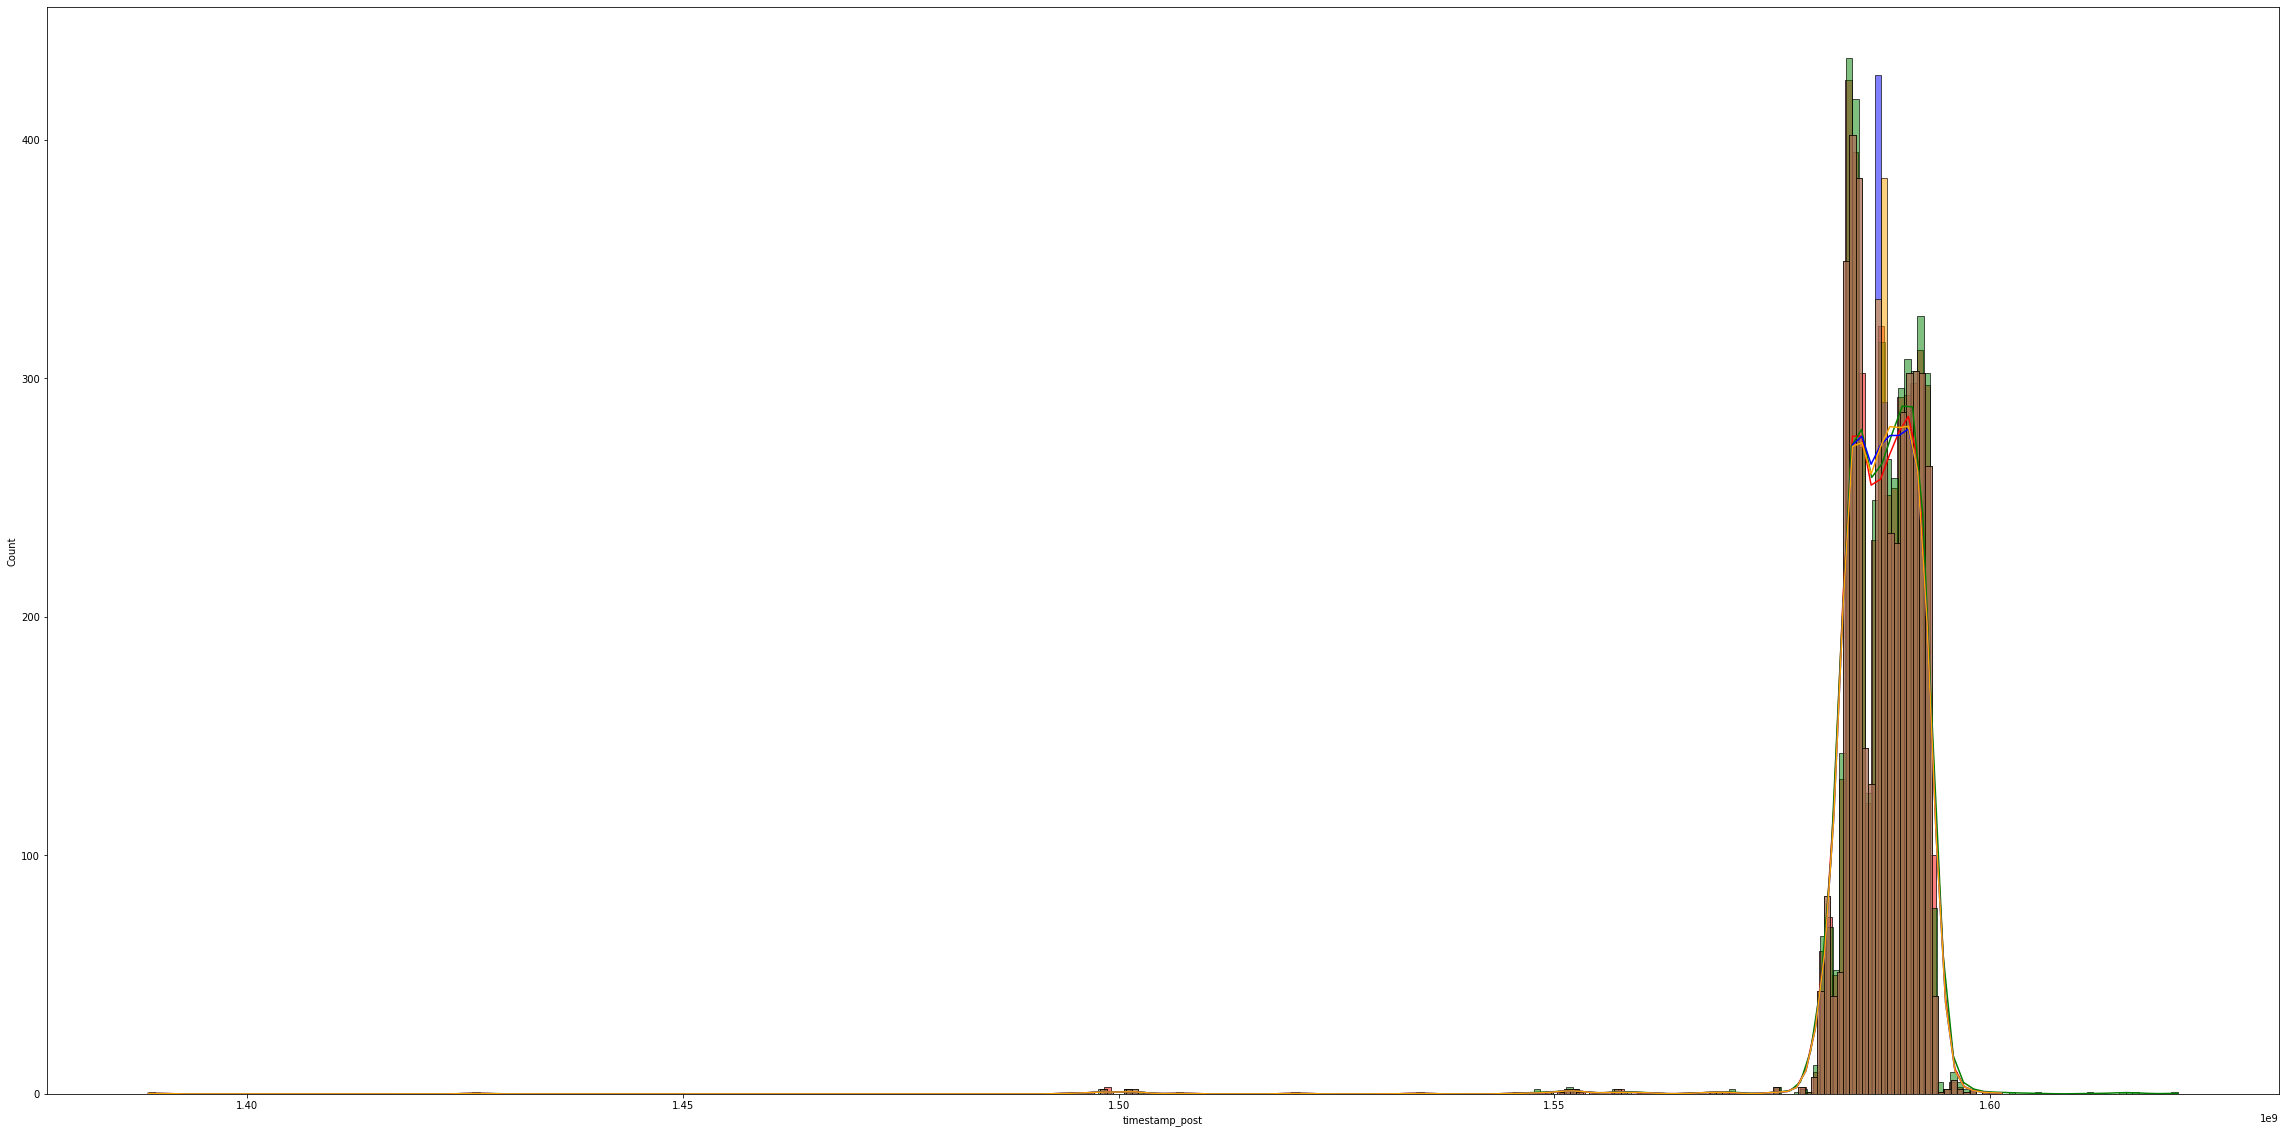

In [ ]:
fig = plt.figure(figsize=(40,20))

sns.histplot(data=df_train,x='timestamp_post',kde=True,color='red')
sns.histplot(test[:,0],kde=True,color='green')
sns.histplot(df_train['timestamp_post'].fillna(df_train['timestamp_post'].mean()),kde=True,color='blue')
sns.histplot(df_train['timestamp_post'].fillna(df_train['timestamp_post'].median()),kde=True,color='orange')

test:

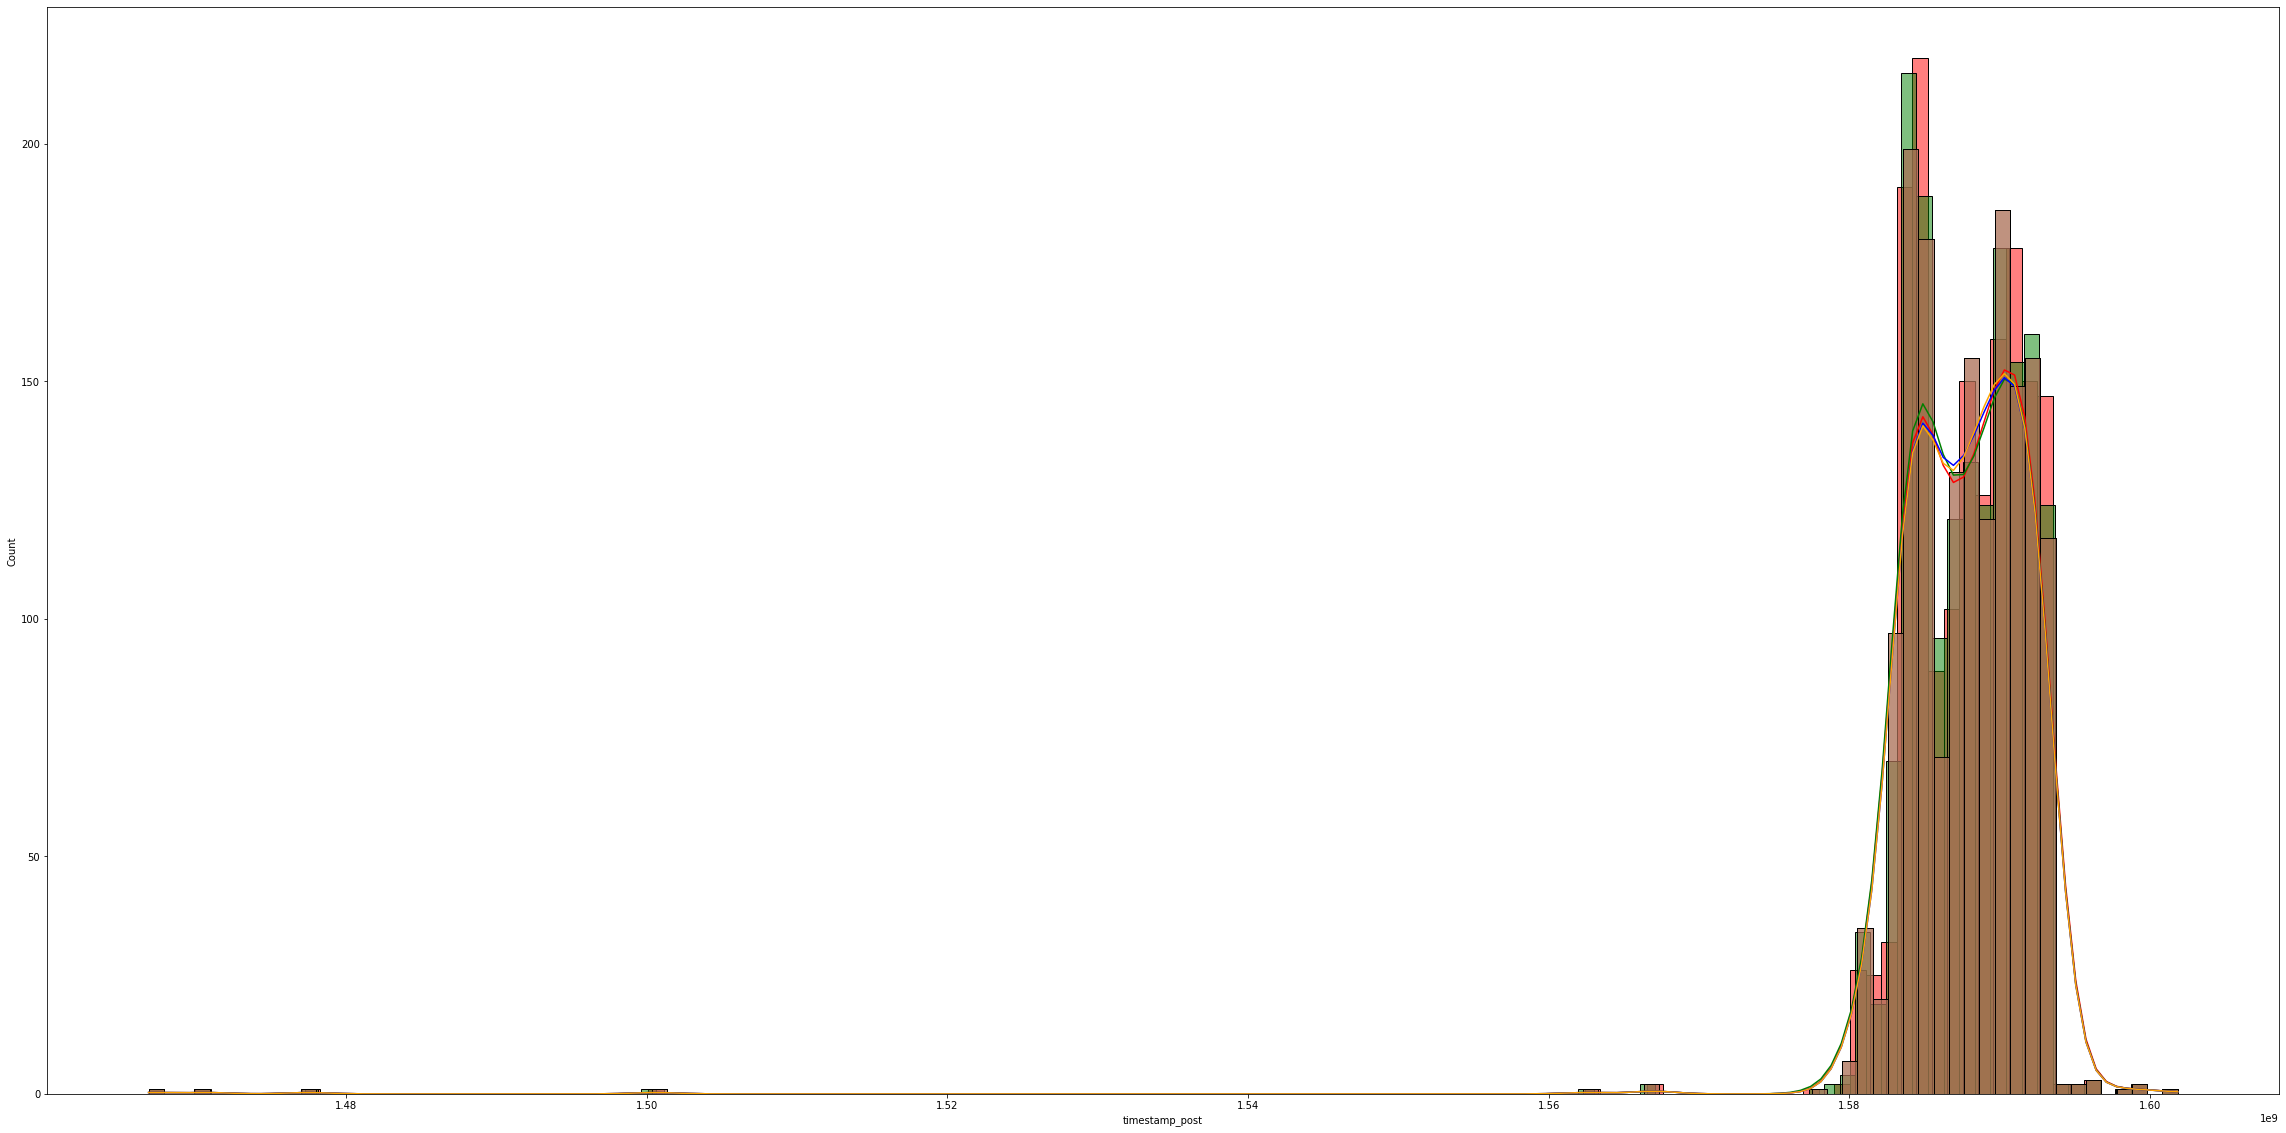

In [ ]:
fig = plt.figure(figsize=(40,20))

sns.histplot(data=df_test,x='timestamp_post',kde=True,color='red')
sns.histplot(test1[:,0],kde=True,color='green')
sns.histplot(df_test['timestamp_post'].fillna(df_test['timestamp_post'].mean()),kde=True,color='blue')
sns.histplot(df_test['timestamp_post'].fillna(df_test['timestamp_post'].median()),kde=True,color='orange')

In [ ]:
#fill missing value as MICE
df_train['timestamp_post'] = test[:,0]

In [ ]:
#fill missing value as MICE
df_pri['timestamp_post'] = test[:,0]

In [ ]:
df_test['timestamp_post'] = test1[:,0]

## Mice Impute

Do when fixing all data

In [ ]:
mice_imputer = IterativeImputer()

test = mice_imputer.fit_transform(df_train[['timestamp_post','num_like_post','num_comment_post','num_share_post']])

In [ ]:
for i in range(1,4):
  for j in range(len(test[:,i])):
    if test[j][i]<0:
      test[j][i]=0
      

In [ ]:
mice_imputer1 = IterativeImputer()

test1 = mice_imputer1.fit_transform(df_test[['timestamp_post','num_like_post','num_comment_post','num_share_post']])

In [ ]:
for i in range(1,4):
  for j in range(len(test1[:,i])):
    if test1[j][i]<0:
      test1[j][i]=0
      

## Num_like_post

In [ ]:
#Finding error
num = []
for i in range(len(df_pri['num_like_post'])):
  try:
    df_pri['num_like_post'][i] = float(df_pri['num_like_post'][i])
    num.append(df_pri['num_like_post'][i])
#   if df_train['num_like_post'][i]>=100000:
#      print("ssssss",i,df_train['num_like_post'][i])
  except:
    print(i,df_pri['num_like_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#Finding error
num = []
for i in range(len(df_train['num_like_post'])):
  try:
    df_train['num_like_post'][i] = float(df_train['num_like_post'][i])
    num.append(df_train['num_like_post'][i])
#   if df_train['num_like_post'][i]>=100000:
#      print("ssssss",i,df_train['num_like_post'][i])
  except:
    print(i,df_train['num_like_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


35 unknown
77 unknown
177 unknown
285 unknown
637 unknown
702 unknown
782 unknown
906 unknown
1151 unknown
1307 unknown
1324 unknown
1417 unknown
1534 unknown
1557 unknown
1797 unknown
1827 unknown
1833 54 like
1855 unknown
1961 unknown
2073 unknown
2162 unknown
2195 unknown
2198 unknown
2215 unknown
2304 unknown
2322 unknown
2325 unknown
2348 unknown
2350 unknown
2410 unknown
2444 unknown
2469 unknown
2496 unknown
2529 unknown
2560 unknown
2563 unknown
2636 unknown
2705 unknown
2710 unknown
2725 unknown
2741 unknown
2918 unknown
2961 unknown
3036 unknown
3046 unknown
3104 unknown
3166 unknown
3177 unknown
3225 unknown
3305 unknown
3357 unknown
3380 unknown
3544 unknown
3635 unknown
3700 unknown
3707 unknown
3725 unknown
3762 unknown
3876 unknown
3900 unknown
4148 unknown
4214 unknown
4248 unknown
4322 unknown
4348 unknown
4351 unknown


In [ ]:
#Finding error
for i in range(len(df_test['num_like_post'])):
  try:
    df_test['num_like_post'][i] = float(df_test['num_like_post'][i])
#   if df_test['num_like_post'][i]>=100000:
#      print("ssssss",i,df_test['num_like_post'][i])
  except:
    print(i,df_test['num_like_post'][i])

116 unknown
209 unknown
218 unknown
246 unknown
310 unknown
358 unknown
416 unknown
436 unknown
451 unknown
485 unknown
487 unknown
510 unknown
518 unknown
550 unknown
559 unknown
574 unknown
585 unknown
644 unknown
694 unknown
698 unknown
751 unknown
939 unknown
989 unknown
1088 unknown
1231 unknown
1294 unknown
1474 unknown
1476 unknown
1533 unknown


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Fixing

In [ ]:
df_train['num_like_post'][1833] = 54
df_train.iloc[1833]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


index                                                            1833
id                                                               1834
user_name                            7ac71da7c5675e5758bf798fa4b344d5
post_message        Hôm nay ra chợ em đã nghe mọi người kháo nhau....
timestamp_post                                            1.58451e+09
num_like_post                                                      54
num_comment_post                                                   20
num_share_post                                                     12
label                                                               1
Name: 1833, dtype: object

In [ ]:
for i in range(len(df_train['num_like_post'])):
  try:
    df_train['num_like_post'][i] = float(df_train['num_like_post'][i])
  except:
    if df_train['num_like_post'][i]=='unknown':
      df_train['num_like_post'][i] = np.nan
    else:
      print(i,df_train['num_like_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(df_test['num_like_post'])):
  try:
    df_test['num_like_post'][i] = float(df_test['num_like_post'][i])
  except:
    if df_test['num_like_post'][i]=='unknown':
      df_test['num_like_post'][i] = np.nan
    else:
      print(i,df_test['num_like_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_train['num_like_post'] = df_train['num_like_post'].astype(float)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4371 non-null   int64  
 1   id                4371 non-null   int64  
 2   user_name         4371 non-null   object 
 3   post_message      4371 non-null   object 
 4   timestamp_post    4275 non-null   float64
 5   num_like_post     4183 non-null   float64
 6   num_comment_post  4357 non-null   object 
 7   num_share_post    3645 non-null   object 
 8   label             4371 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 307.5+ KB


In [ ]:
df_test['num_like_post'] = df_test['num_like_post'].astype(float)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1642 non-null   int64  
 1   user_name         1642 non-null   object 
 2   post_message      1642 non-null   object 
 3   timestamp_post    1614 non-null   float64
 4   num_like_post     1571 non-null   float64
 5   num_comment_post  1635 non-null   object 
 6   num_share_post    1363 non-null   object 
 7   cleaned_text      1642 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 102.8+ KB


In [ ]:
df_pri['num_like_post'] = df_pri['num_like_post'].astype(float)
df_pri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1030 non-null   float64
 5   num_comment_post  969 non-null    object 
 6   num_share_post    904 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 90.1+ KB


### Plot and fill missing

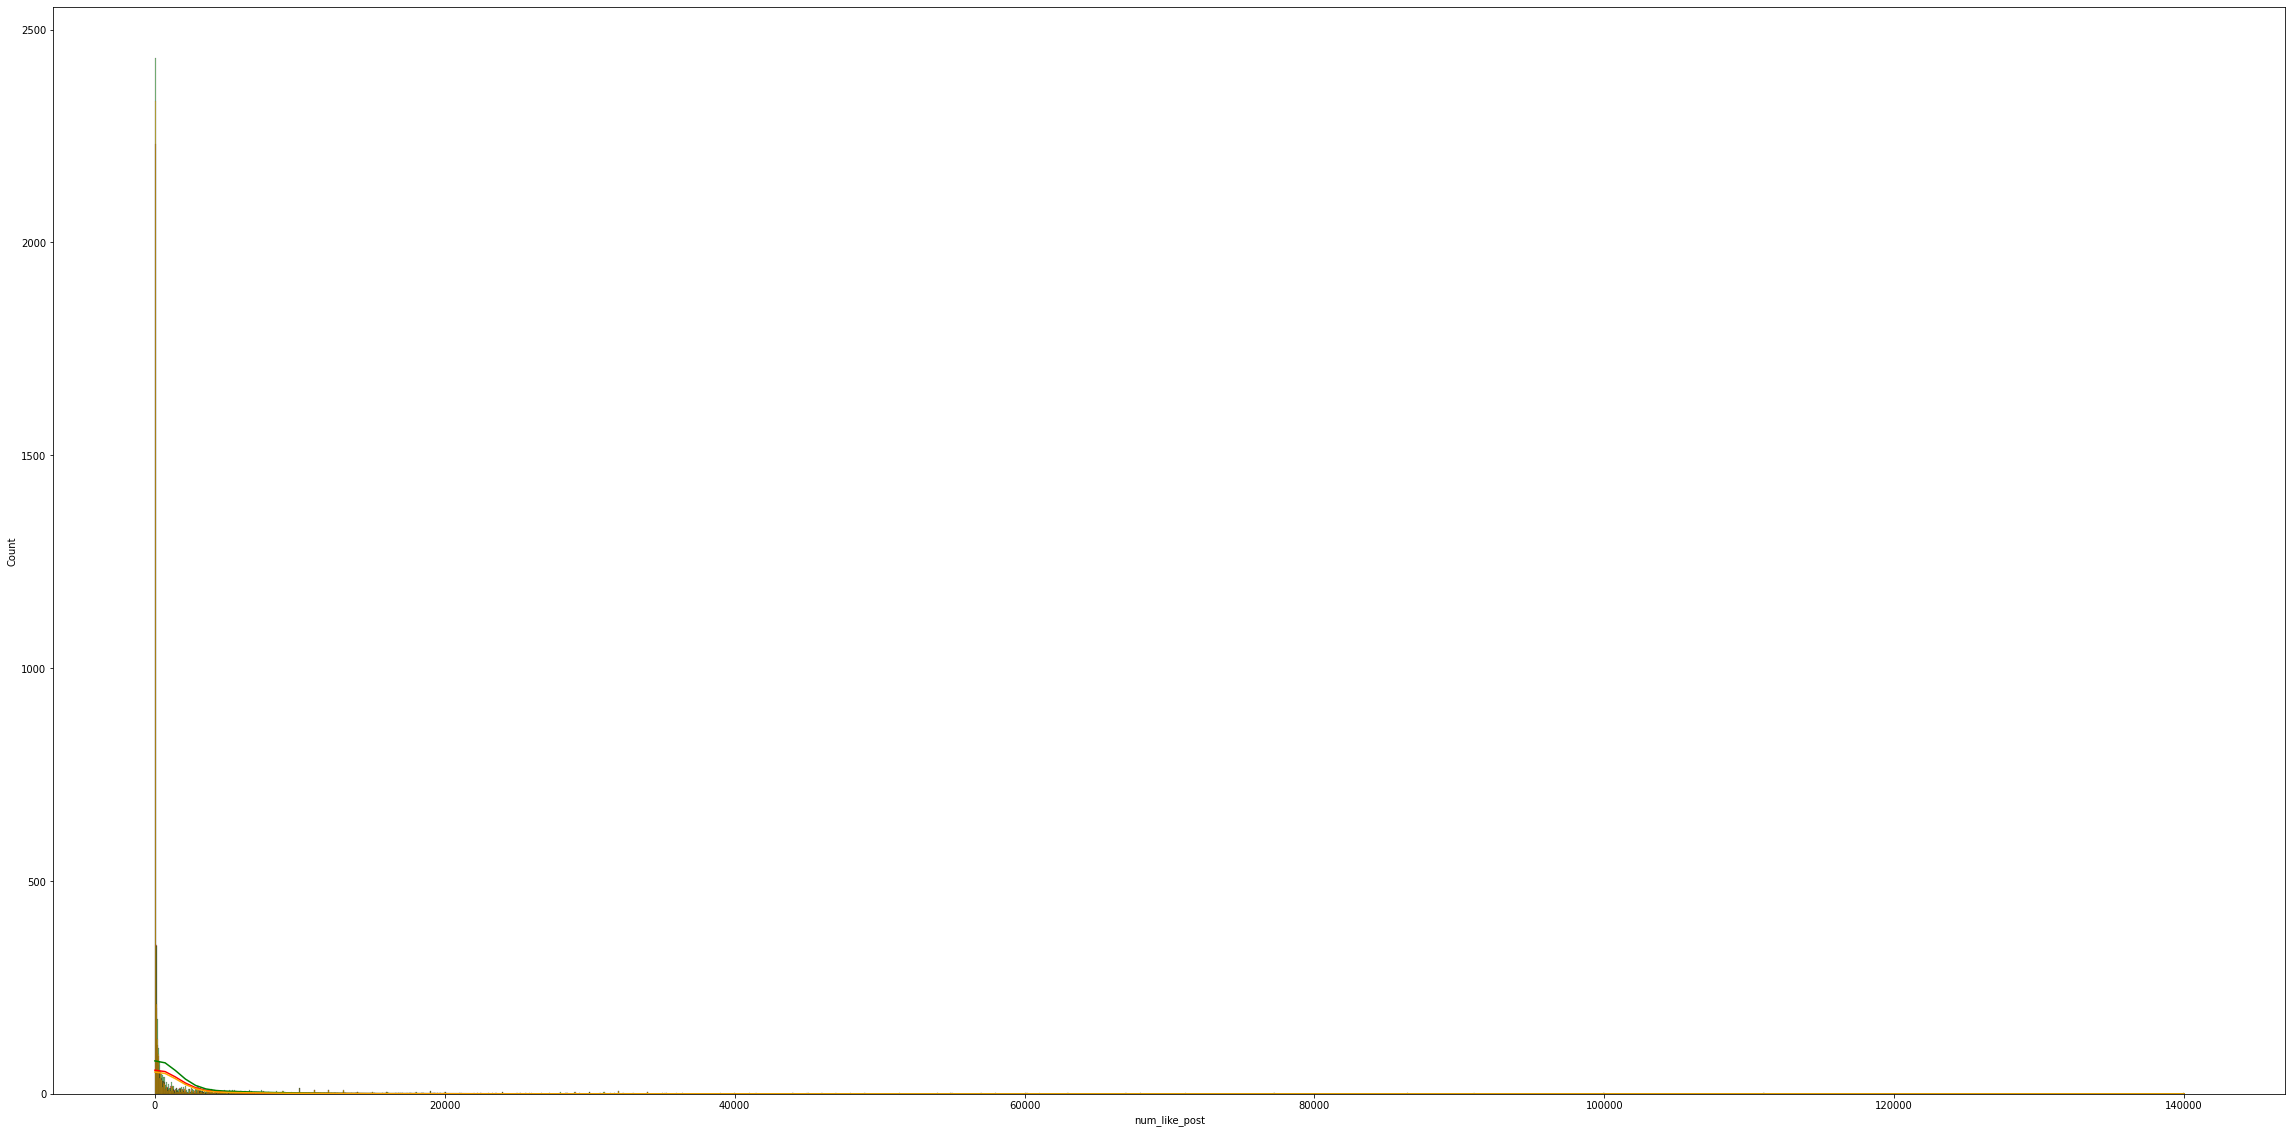

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_train,x='num_like_post',kde=True,color='red')
#sns.histplot(test[:,1],kde=True,color='green')
#sns.histplot(df_train['num_like_post'].fillna(df_train['num_like_post'].mean()),kde=True,color='blue')
sns.histplot(df_train['num_like_post'].fillna(df_train['num_like_post'].median()),kde=True,color='orange')

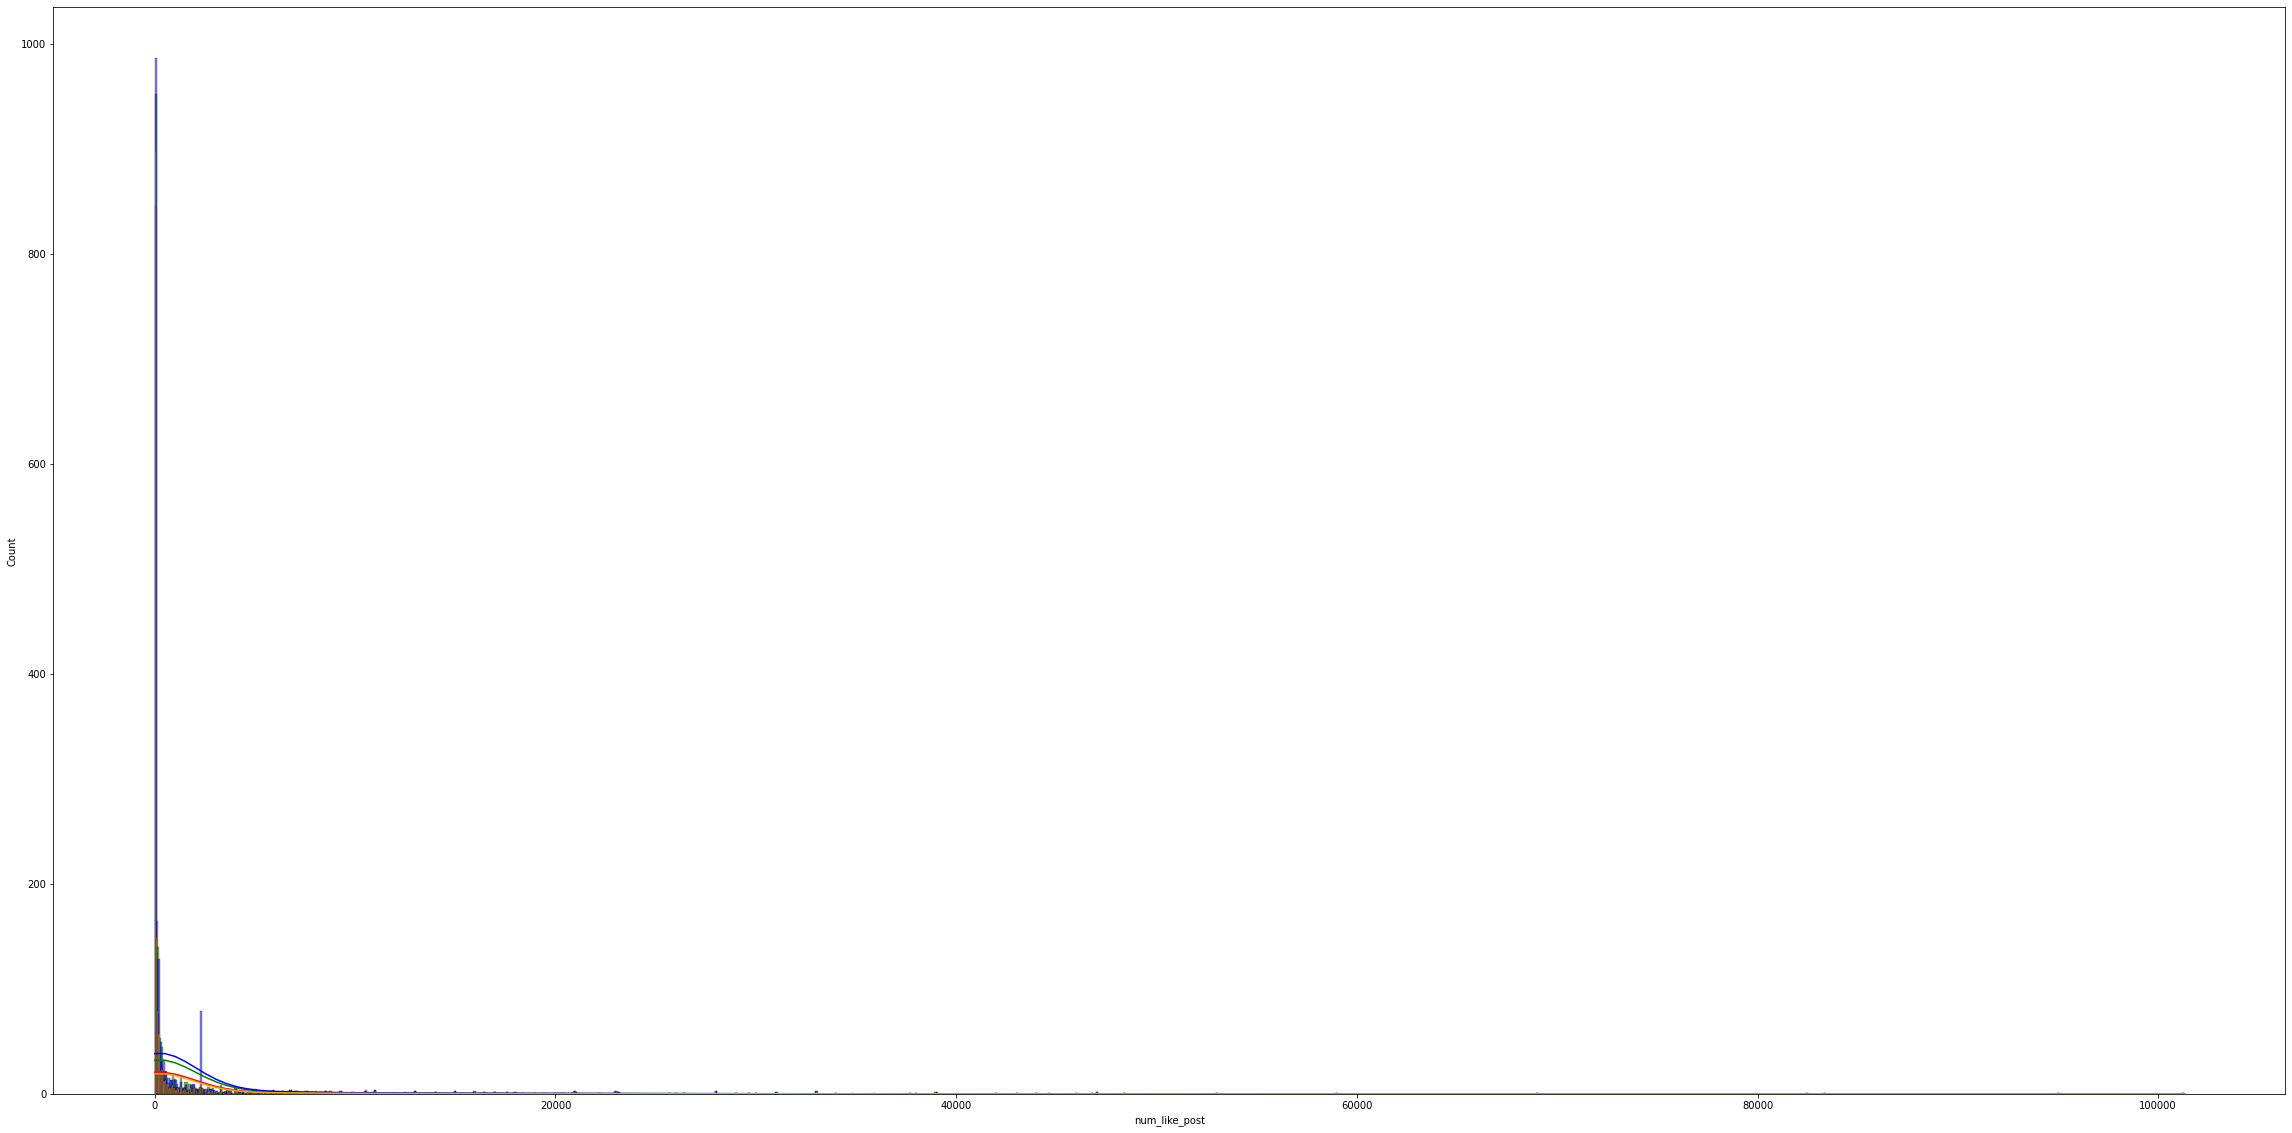

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_test,x='num_like_post',kde=True,color='red')
sns.histplot(test1[:,1],kde=True,color='green')
sns.histplot(df_test['num_like_post'].fillna(df_test['num_like_post'].mean()),kde=True,color='blue')
sns.histplot(df_test['num_like_post'].fillna(df_test['num_like_post'].median()),kde=True,color='orange')

In [ ]:
#Fill missing values as median
df_train['num_like_post'] = df_train['num_like_post'].fillna(df_train['num_like_post'].median())

In [ ]:
df_test['num_like_post'] = df_test['num_like_post'].fillna(df_test['num_like_post'].median())

In [ ]:
df_pri['num_like_post'] = df_pri['num_like_post'].fillna(df_pri['num_like_post'].median())

## Num_comment

In [ ]:
num_comment = []
for i in range(len(df_pri['num_comment_post'])):
  try:
    df_pri['num_comment_post'][i] = float(df_pri['num_comment_post'][i])
    num_comment.append(df_pri['num_comment_post'][i])
  except:
    print(i,df_pri['num_comment_post'][i])

1605 1 comment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
num_comment = []
for i in range(len(df_train['num_comment_post'])):
  try:
    df_train['num_comment_post'][i] = float(df_train['num_comment_post'][i])
    num_comment.append(df_train['num_comment_post'][i])
  except:
    print(i,df_train['num_comment_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


35 unknown
77 unknown
177 unknown
189 1 comment
285 unknown
298 1 comment
637 unknown
702 unknown
782 unknown
906 unknown
1151 unknown
1307 unknown
1324 unknown
1417 unknown
1534 unknown
1557 unknown
1797 unknown
1827 unknown
1855 unknown
1961 unknown
2073 unknown
2162 unknown
2195 unknown
2198 unknown
2215 unknown
2277 1 comment
2304 unknown
2322 unknown
2325 unknown
2348 unknown
2350 unknown
2410 unknown
2444 unknown
2469 unknown
2496 unknown
2529 unknown
2560 unknown
2563 unknown
2636 unknown
2705 unknown
2710 unknown
2718 10 comment
2725 unknown
2741 unknown
2918 unknown
2961 unknown
3036 unknown
3046 unknown
3104 unknown
3166 unknown
3177 unknown
3211 1 comment
3225 unknown
3305 unknown
3357 unknown
3380 unknown
3537 12 comment
3544 unknown
3635 unknown
3700 unknown
3707 unknown
3725 unknown
3762 unknown
3811 1 comment
3876 unknown
3900 unknown
4148 unknown
4214 unknown
4248 unknown
4322 unknown
4348 unknown
4351 unknown


In [ ]:
#Test data
for i in range(len(df_test['num_comment_post'])):
  try:
    df_test['num_comment_post'][i] = float(df_test['num_comment_post'][i])
    num_comment.append(df_test['num_comment_post'][i])
  except:
    print(i,df_test['num_comment_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


116 unknown
209 unknown
218 unknown
246 unknown
310 unknown
358 unknown
416 unknown
436 unknown
451 unknown
458 1 comment
485 unknown
487 unknown
510 unknown
518 unknown
550 unknown
559 unknown
574 unknown
585 unknown
644 unknown
694 unknown
698 unknown
751 unknown
939 unknown
989 unknown
1088 unknown
1227 19 comment
1231 unknown
1294 unknown
1474 unknown
1476 unknown
1533 unknown


### Fixing

In [ ]:
df_pri['num_comment_post'][1605] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train['num_comment_post'][189] = 1
df_train['num_comment_post'][298] = 1
df_train['num_comment_post'][2277] = 1
df_train['num_comment_post'][2718] = 10
df_train['num_comment_post'][3211] = 1
df_train['num_comment_post'][3537] = 12
df_train['num_comment_post'][3811] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
df_test['num_comment_post'][458] = 1
df_test['num_comment_post'][1227] = 19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(df_pri['num_comment_post'])):
  try:
    df_pri['num_comment_post'][i] = float(df_pri['num_comment_post'][i])
  except:
    if df_pri['num_comment_post'][i]=='unknown':
      df_pri['num_comment_post'][i] = np.nan
    else:
      print(i,df_pri['num_comment_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_train['num_comment_post'])):
  try:
    df_train['num_comment_post'][i] = float(df_train['num_comment_post'][i])
  except:
    if df_train['num_comment_post'][i]=='unknown':
      df_train['num_comment_post'][i] = np.nan
    else:
      print(i,df_train['num_comment_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(df_test['num_comment_post'])):
  try:
    df_test['num_comment_post'][i] = float(df_test['num_comment_post'][i])
  except:
    if df_test['num_comment_post'][i]=='unknown':
      df_test['num_comment_post'][i] = np.nan
    else:
      print(i,df_test['num_comment_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_train['num_comment_post'] = df_train['num_comment_post'].astype(float)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4371 non-null   int64  
 1   id                4371 non-null   int64  
 2   user_name         4371 non-null   object 
 3   post_message      4371 non-null   object 
 4   timestamp_post    4275 non-null   float64
 5   num_like_post     4371 non-null   float64
 6   num_comment_post  4292 non-null   float64
 7   num_share_post    3645 non-null   object 
 8   label             4371 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 307.5+ KB


In [ ]:
df_pri['num_comment_post'] = df_pri['num_comment_post'].astype(float)
df_pri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1646 non-null   float64
 5   num_comment_post  969 non-null    float64
 6   num_share_post    904 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 90.1+ KB


In [ ]:
df_test['num_comment_post'] = df_test['num_comment_post'].astype(float)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1642 non-null   int64  
 1   user_name         1642 non-null   object 
 2   post_message      1642 non-null   object 
 3   timestamp_post    1614 non-null   float64
 4   num_like_post     1642 non-null   float64
 5   num_comment_post  1606 non-null   float64
 6   num_share_post    1363 non-null   object 
 7   cleaned_text      1642 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 102.8+ KB


### Plot and fill missing

Train:

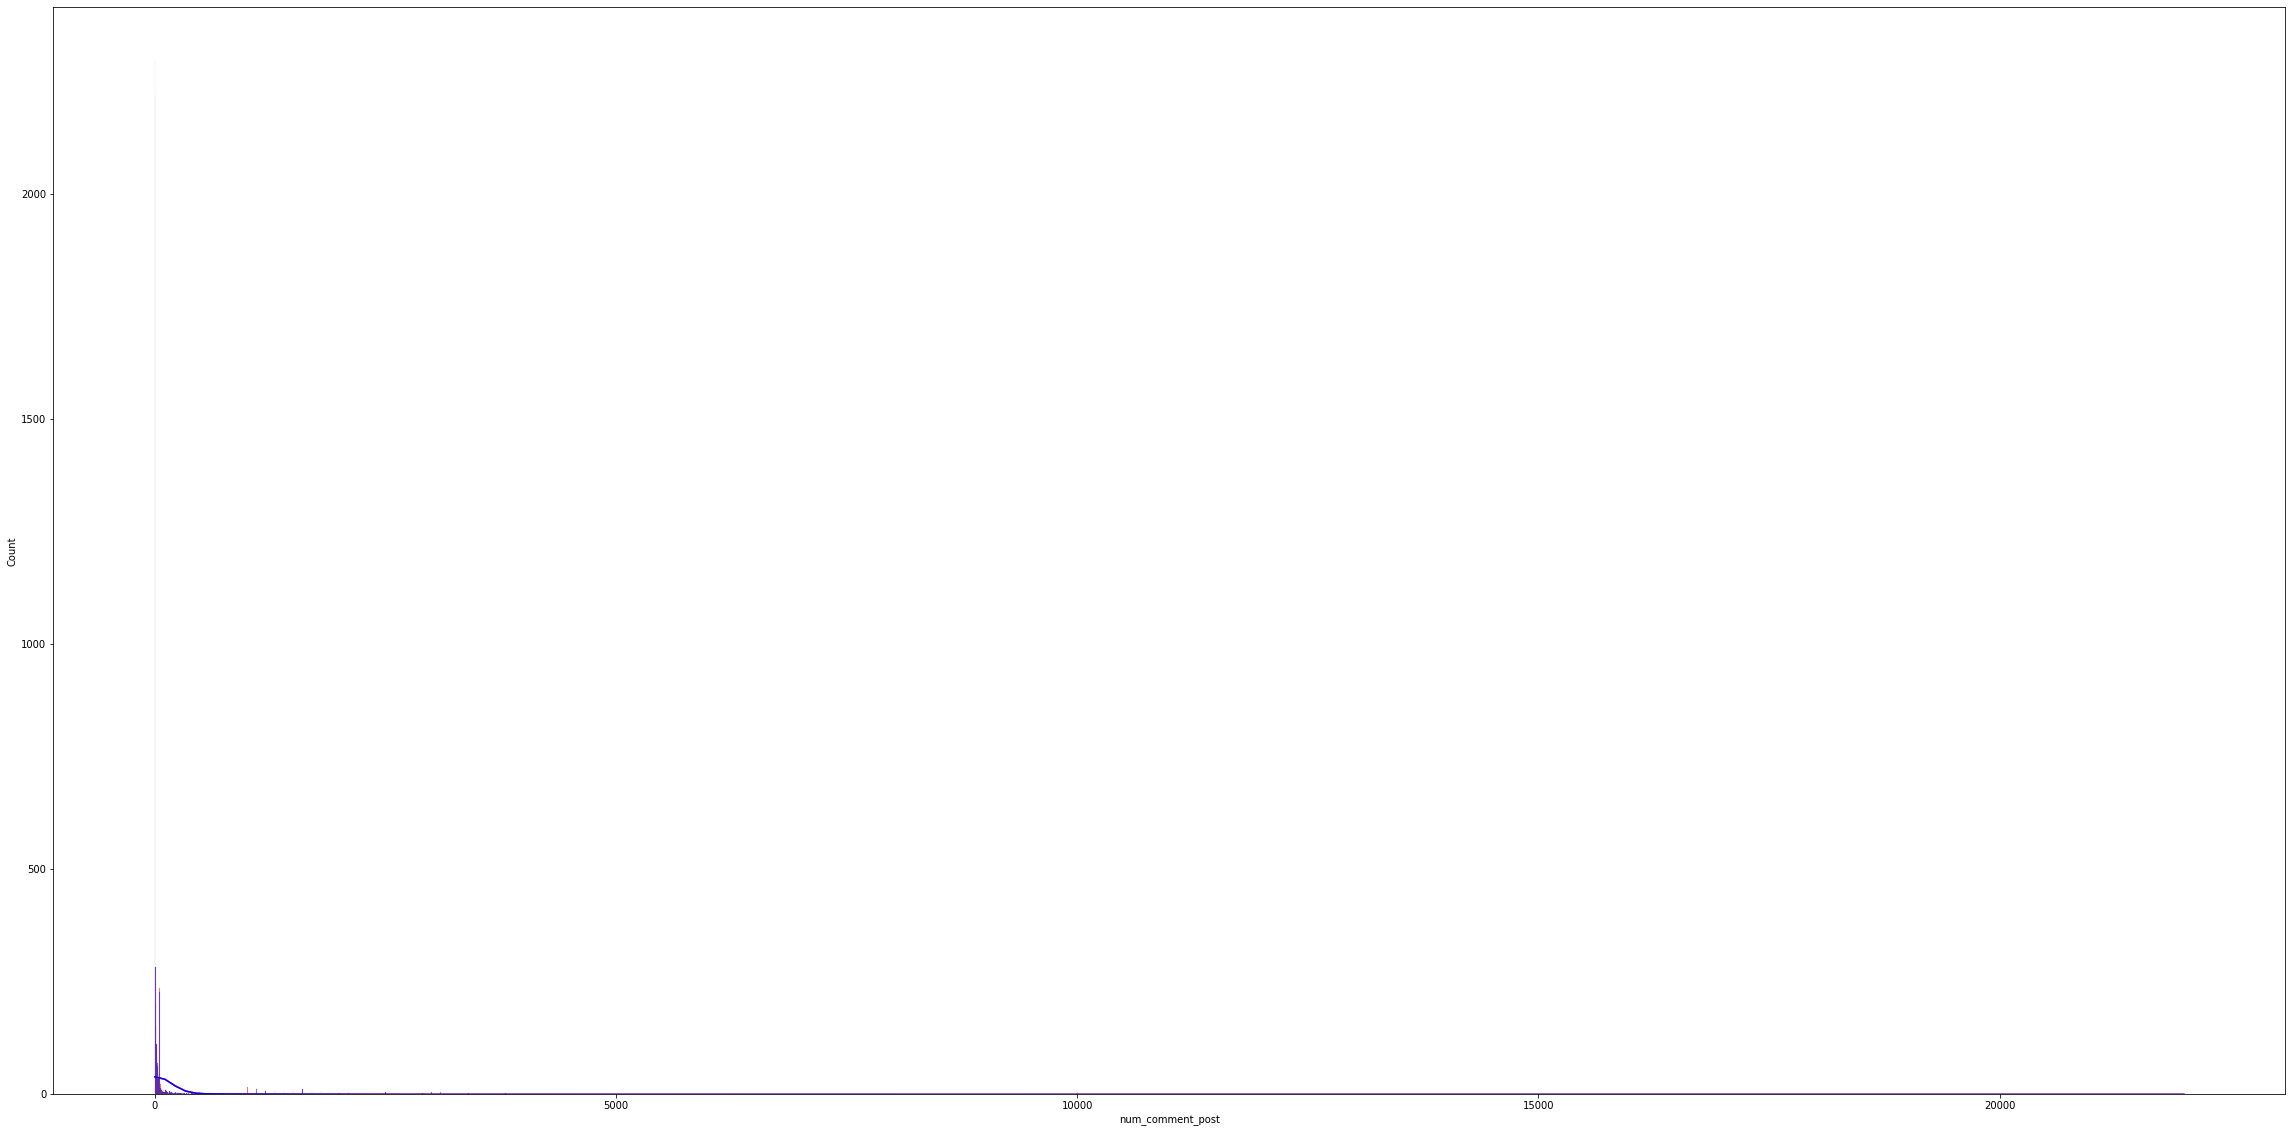

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_train,x='num_comment_post',kde=True,color='red')
#sns.histplot(test[:,2],kde=True,color='green')
#sns.histplot(df_train['num_comment_post'].fillna(df_train['num_comment_post'].mean()),kde=True,color='blue')
sns.histplot(df_train['num_comment_post'].fillna(df_train['num_comment_post'].median()),kde=True,color='blue')

test:

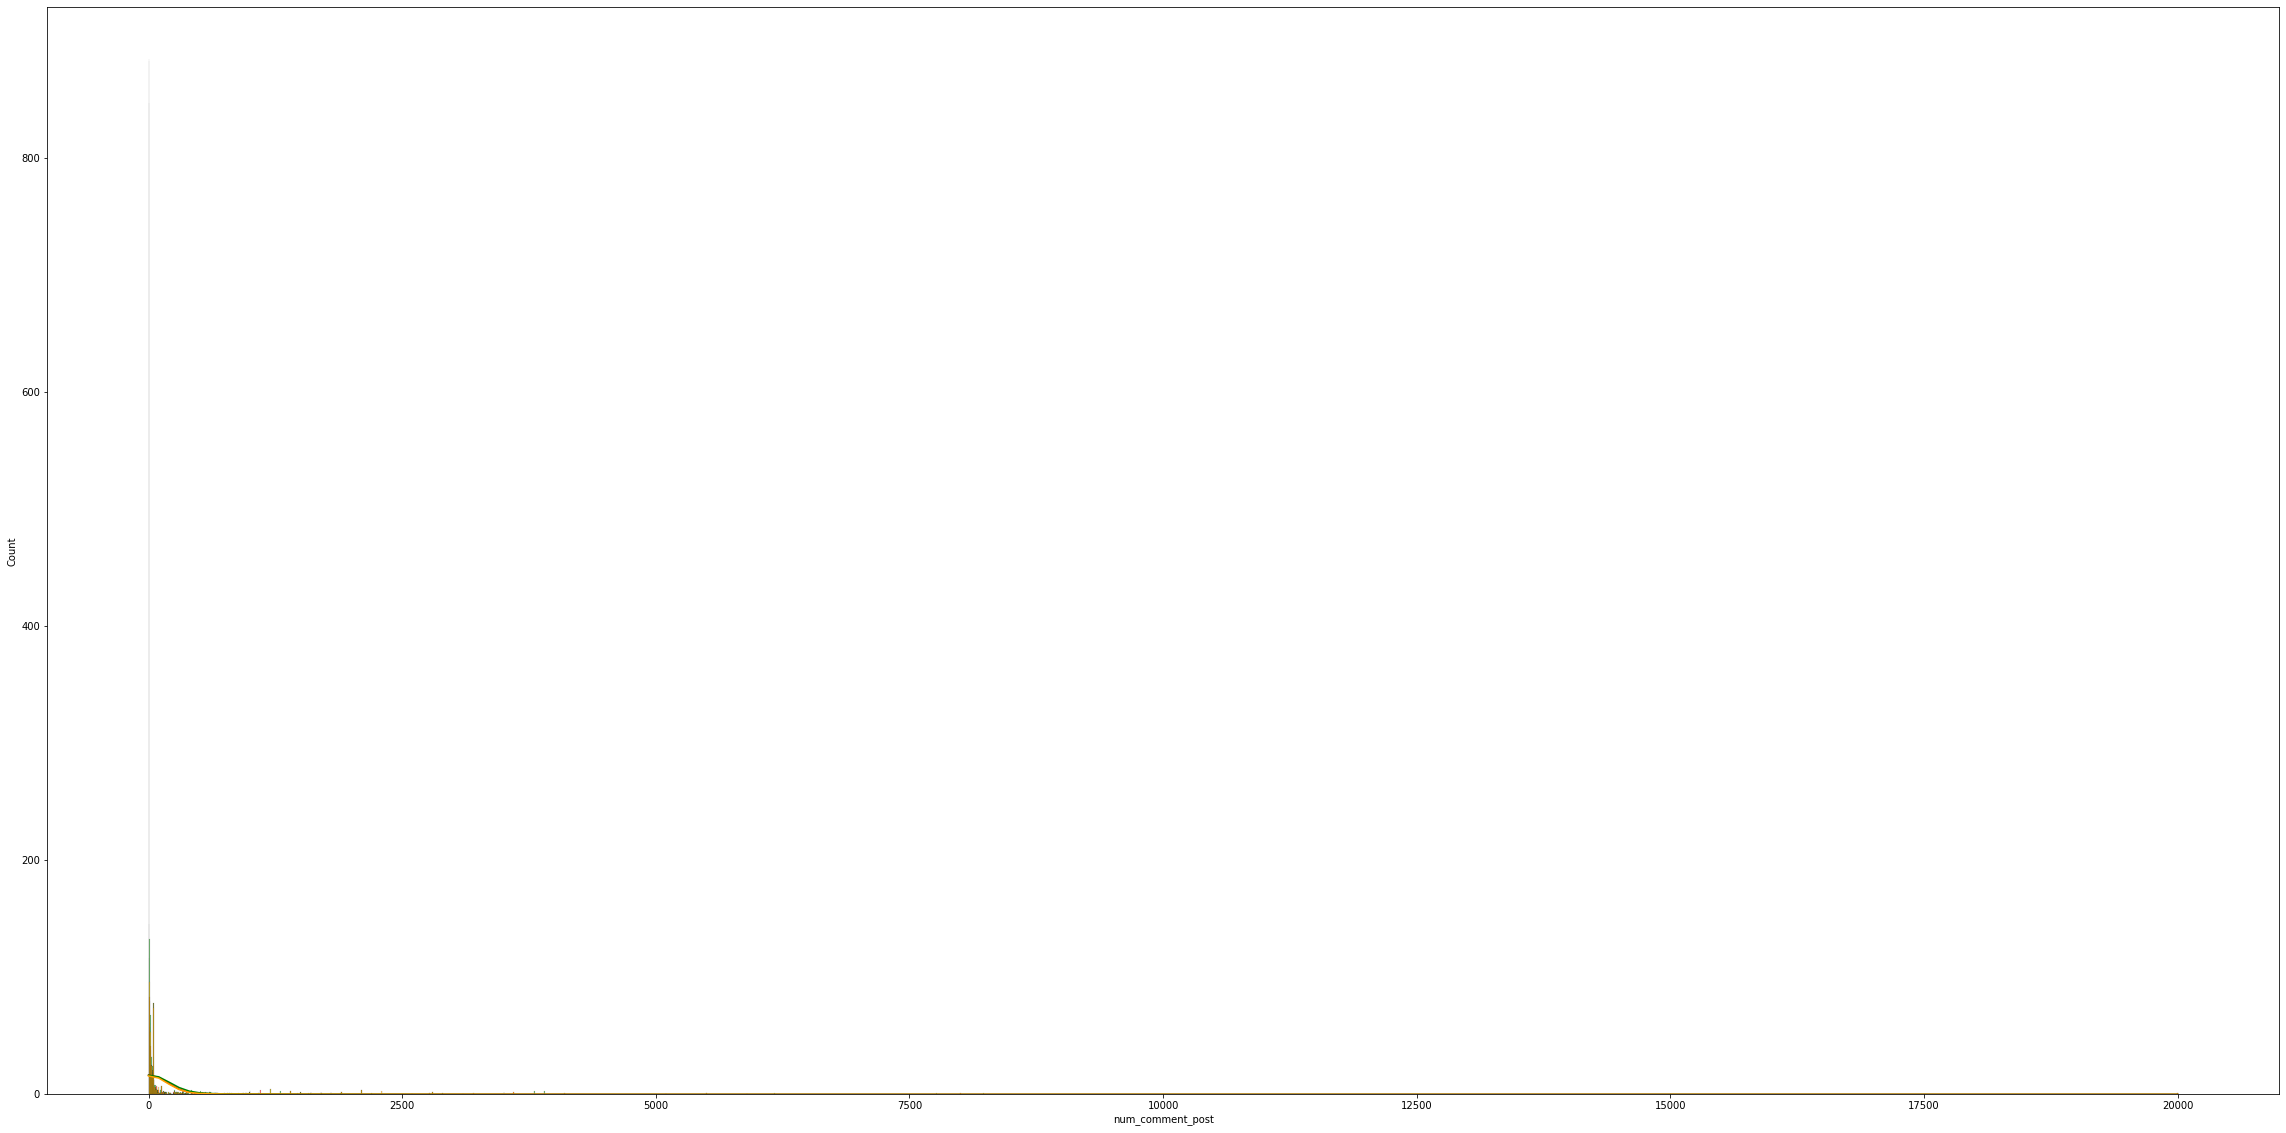

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_test,x='num_comment_post',kde=True,color='red')
sns.histplot(test1[:,2],kde=True,color='green')
#sns.histplot(df_test['num_comment_post'].fillna(df_test['num_comment_post'].mean()),kde=True,color='blue')
sns.histplot(df_test['num_comment_post'].fillna(df_test['num_comment_post'].median()),kde=True,color='orange')

In [ ]:
#Fill median
df_train['num_comment_post'] = df_train['num_comment_post'].fillna(df_train['num_comment_post'].median())

In [ ]:
df_test['num_comment_post'] = df_test['num_comment_post'].fillna(df_test['num_comment_post'].median())

In [ ]:
df_pri['num_comment_post'] = df_pri['num_comment_post'].fillna(df_pri['num_comment_post'].median())

## Num_share_post

In [ ]:
num_share = []
for i in range(len(df_pri['num_share_post'])):
  try:
    df_pri['num_share_post'][i] = float(df_pri['num_share_post'][i])
    num_share.append(df_pri['num_share_post'][i])
    if df_pri['num_share_post'][i]>1000000:
      print('sssss',df_pri['num_share_post'][i],i)
  except:
    print(i,df_pri['num_share_post'][i])

176 1 share
1447 1 share


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
num_share = []
for i in range(len(df_train['num_share_post'])):
  try:
    df_train['num_share_post'][i] = float(df_train['num_share_post'][i])
    num_share.append(df_train['num_share_post'][i])
    if df_train['num_share_post'][i]>1000000:
      print('sssss',df_train['num_share_post'][i],i)
  except:
    print(i,df_train['num_share_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


35 unknown
77 unknown
177 unknown
285 unknown
388 1 share
637 unknown
702 unknown
782 unknown
906 unknown
921 1 share
1110 1 share
1151 unknown
1307 unknown
1324 unknown
1417 unknown
1534 unknown
1557 unknown
1797 unknown
1827 unknown
1855 unknown
1961 unknown
1971 1 share
2073 unknown
2162 unknown
2195 unknown
2198 unknown
2214 1 share
2215 unknown
2304 unknown
2322 unknown
2325 unknown
2348 unknown
2350 unknown
2410 unknown
2444 unknown
2469 unknown
2496 unknown
2529 unknown
2560 unknown
2563 unknown
2636 unknown
2705 unknown
2710 unknown
2725 unknown
2741 unknown
2841 June 11th 2020, 19:03:45.000
2918 unknown
2961 unknown
3036 unknown
3046 unknown
3104 unknown
3144 1 share
3166 unknown
3177 unknown
3225 unknown
3305 unknown
3357 unknown
3380 unknown
3544 unknown
3635 unknown
3700 unknown
3707 unknown
3725 unknown
3762 unknown
3838 1 share
3876 unknown
3900 unknown
3922 1 share
4035 May 25th 2020, 21:57:58.000
4148 unknown
4214 unknown
4248 unknown
4322 unknown
4348 unknown
4351 unkn

In [ ]:
for i in range(len(df_test['num_share_post'])):
  try:
    df_test['num_share_post'][i] = float(df_test['num_share_post'][i])
  #  if df_test['num_share_post'][i]>1000000:
  #    print('sssss',df_test['num_share_post'][i],i)
  except:
    print(i,df_test['num_share_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


116 unknown
209 unknown
218 unknown
246 unknown
310 unknown
358 unknown
416 unknown
436 unknown
451 unknown
485 unknown
487 unknown
510 unknown
518 unknown
550 unknown
559 unknown
574 unknown
585 unknown
602 1 share
644 unknown
694 unknown
698 unknown
714 1 share
751 unknown
939 unknown
989 unknown
1055 1 share
1088 unknown
1231 unknown
1294 unknown
1474 unknown
1476 unknown
1533 unknown


### Fixing

In [ ]:
df_pri['num_share_post'][176] = 1
df_pri['num_share_post'][1447] = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_train['num_share_post'][388] = 1
df_train['num_share_post'][921] = 1
df_train['num_share_post'][1110] = 1
df_train['num_share_post'][1971] = 1
df_train['num_share_post'][2214] = 1
df_train['num_share_post'][3144] = 1
df_train['num_share_post'][3838] = 1
df_train['num_share_post'][3922] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
df_test['num_share_post'][602] = 1
df_test['num_share_post'][714] = 1
df_test['num_share_post'][1055] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
print(df_train.iloc[4035])
print(df_train.iloc[2841])

index                                                            4036
id                                                               4037
user_name                            9515e17e4fd91a7165c6f0226a2e94d1
post_message        Sở GD&ĐT Hải Phòng đã có chỉ đạo tới các trườn...
timestamp_post                                                    NaN
num_like_post                                                      45
num_comment_post                                                    1
num_share_post                            May 25th 2020, 21:57:58.000
label                                                               0
cleaned_text        sở giám_đốc & đt hải_phòng đã có chỉ_đạo tới c...
Name: 4035, dtype: object
index                                                            2842
id                                                               2843
user_name                            96b7f52c620680c848f55e7cb6e3e90f
post_message        Anh Hồ Văn L., gia đình có 9 nhân khẩu, nhận

In [ ]:
from datetime import datetime,timezone
arr = [4035,2841]
for i in arr:
  dt = datetime.strptime(df_train['num_share_post'][i], '%B %dth %Y, %H:%M:%S.%f')
  timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
  df_train['timestamp_post'][i] = timestamp
  df_train['num_share_post'][i] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
print(df_train.iloc[4035])
print(df_train.iloc[2841])

index                                                            4036
id                                                               4037
user_name                            9515e17e4fd91a7165c6f0226a2e94d1
post_message        Sở GD&ĐT Hải Phòng đã có chỉ đạo tới các trườn...
timestamp_post                                            1.59044e+09
num_like_post                                                      45
num_comment_post                                                    1
num_share_post                                                    NaN
label                                                               0
cleaned_text        sở giám_đốc & đt hải_phòng đã có chỉ_đạo tới c...
Name: 4035, dtype: object
index                                                            2842
id                                                               2843
user_name                            96b7f52c620680c848f55e7cb6e3e90f
post_message        Anh Hồ Văn L., gia đình có 9 nhân khẩu, nhận

In [ ]:
for i in range(len(df_pri['num_share_post'])):
  try:
    df_pri['num_share_post'][i] = float(df_pri['num_share_post'][i])
  except:
    if df_pri['num_share_post'][i]=='unknown':
      df_pri['num_share_post'][i] = np.nan
    else:
      print(i,df_pri['num_share_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_train['num_share_post'])):
  try:
    df_train['num_share_post'][i] = float(df_train['num_share_post'][i])
  except:
    if df_train['num_share_post'][i]=='unknown':
      df_train['num_share_post'][i] = np.nan
    else:
      print(i,df_train['num_share_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(df_test['num_share_post'])):
  try:
    df_test['num_share_post'][i] = float(df_test['num_share_post'][i])
  except:
    if df_test['num_share_post'][i]=='unknown':
      df_test['num_share_post'][i] = np.nan
    else:
      print(i,df_test['num_share_post'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_train['num_share_post'] = df_train['num_share_post'].astype(float)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4371 non-null   int64  
 1   id                4371 non-null   int64  
 2   user_name         4371 non-null   object 
 3   post_message      4371 non-null   object 
 4   timestamp_post    4277 non-null   float64
 5   num_like_post     4371 non-null   float64
 6   num_comment_post  4371 non-null   float64
 7   num_share_post    3578 non-null   float64
 8   label             4371 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 307.5+ KB


In [ ]:
df_pri['num_share_post'] = df_pri['num_share_post'].astype(float)
df_pri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1646 non-null   float64
 5   num_comment_post  1646 non-null   float64
 6   num_share_post    904 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 90.1+ KB


In [ ]:
df_test['num_share_post'] = df_test['num_share_post'].astype(float)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1642 non-null   int64  
 1   user_name         1642 non-null   object 
 2   post_message      1642 non-null   object 
 3   timestamp_post    1614 non-null   float64
 4   num_like_post     1642 non-null   float64
 5   num_comment_post  1642 non-null   float64
 6   num_share_post    1334 non-null   float64
 7   cleaned_text      1642 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 102.8+ KB


### Plot and fill missing

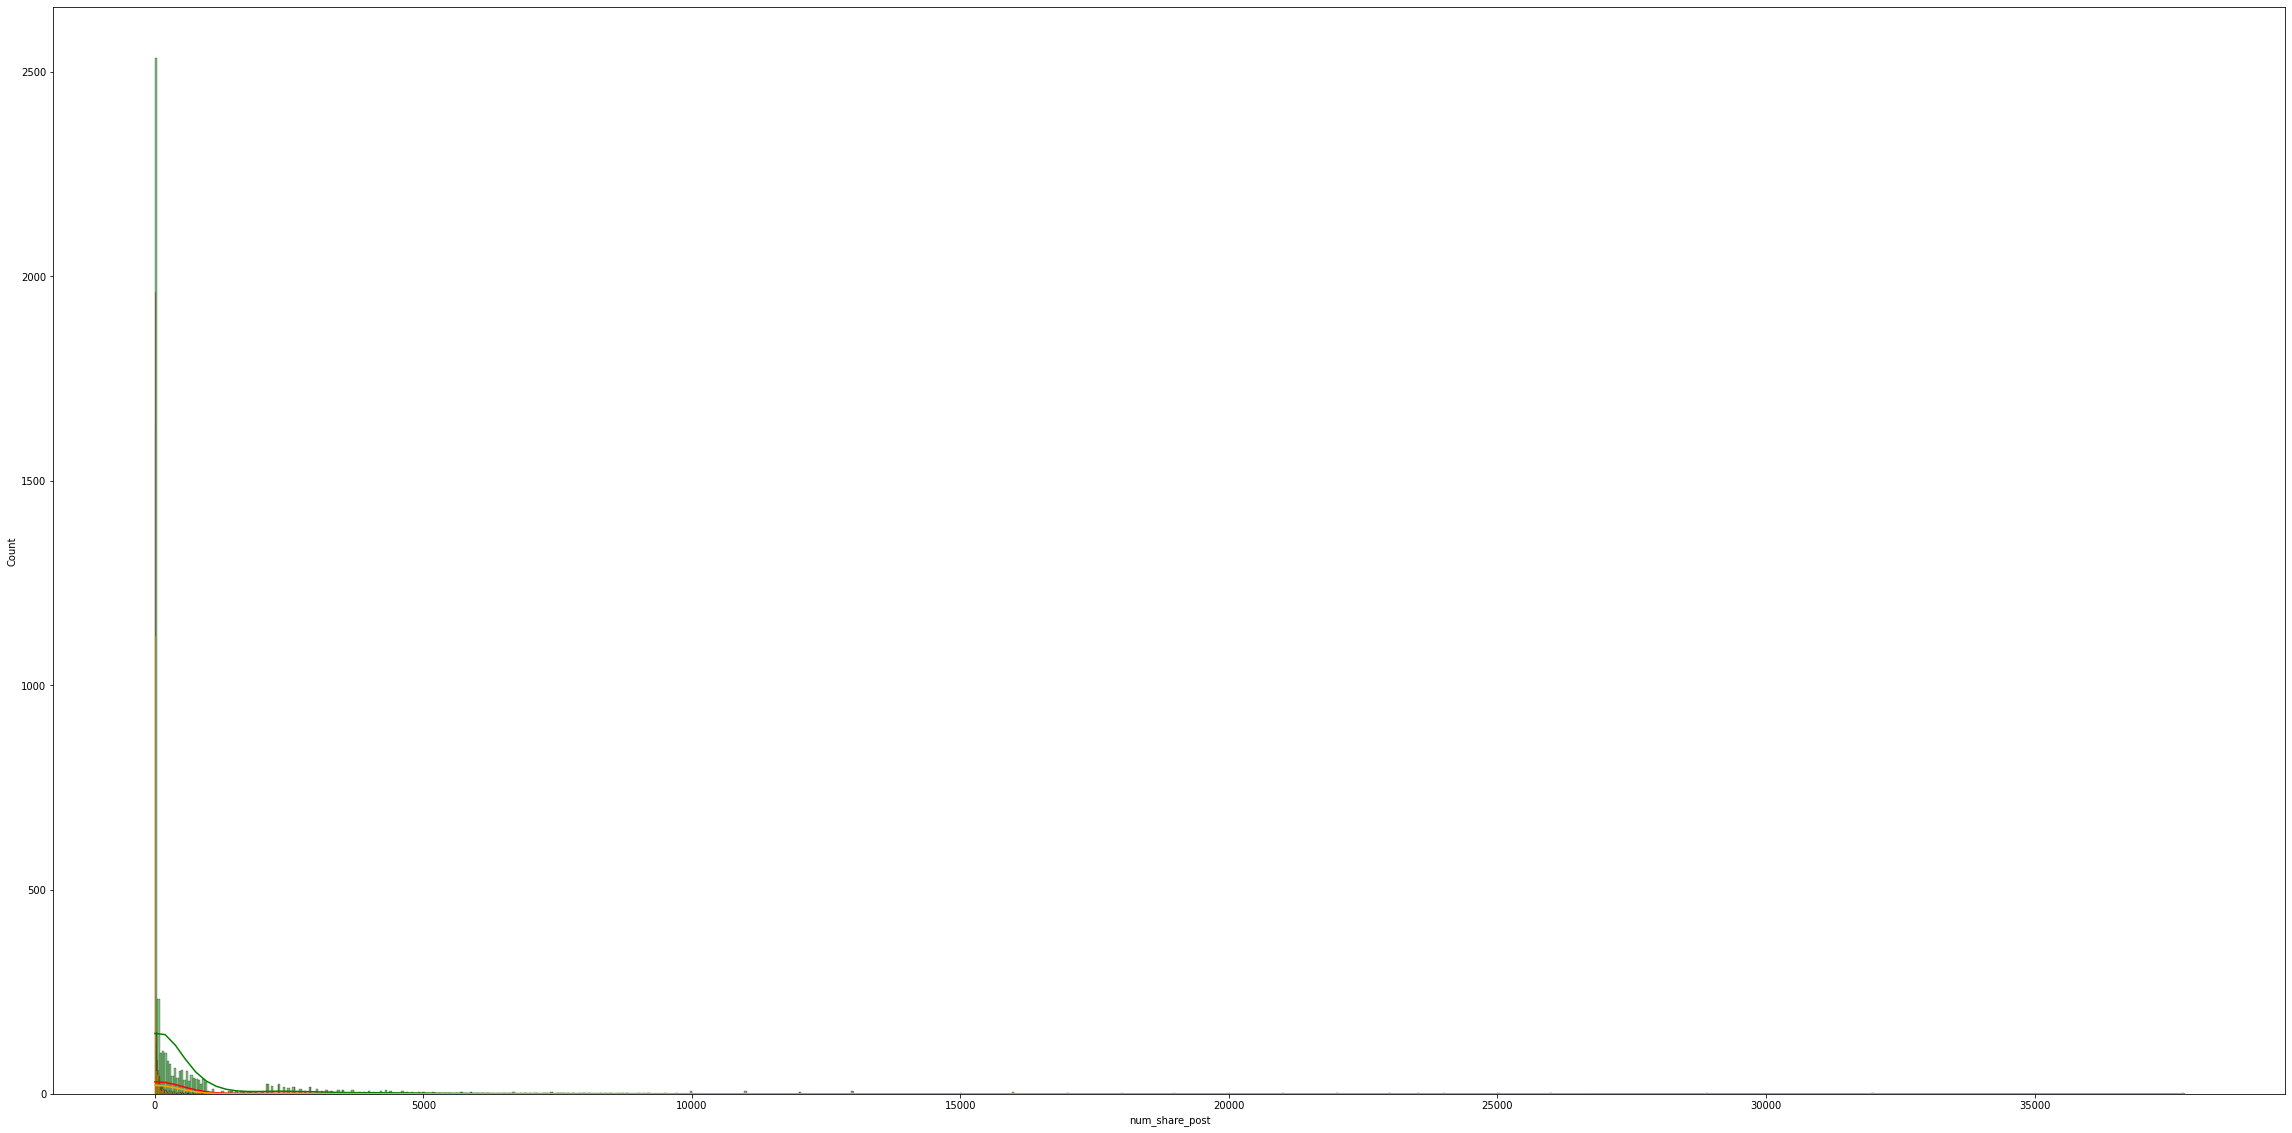

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_train,x='num_share_post',kde=True,color='red')
sns.histplot(test[:,3],kde=True,color='green')
#sns.histplot(df_train['num_share_post'].fillna(df_train['num_share_post'].mean()),kde=True,color='blue')
sns.histplot(df_train['num_share_post'].fillna(df_train['num_share_post'].median()),kde=True,color='orange')

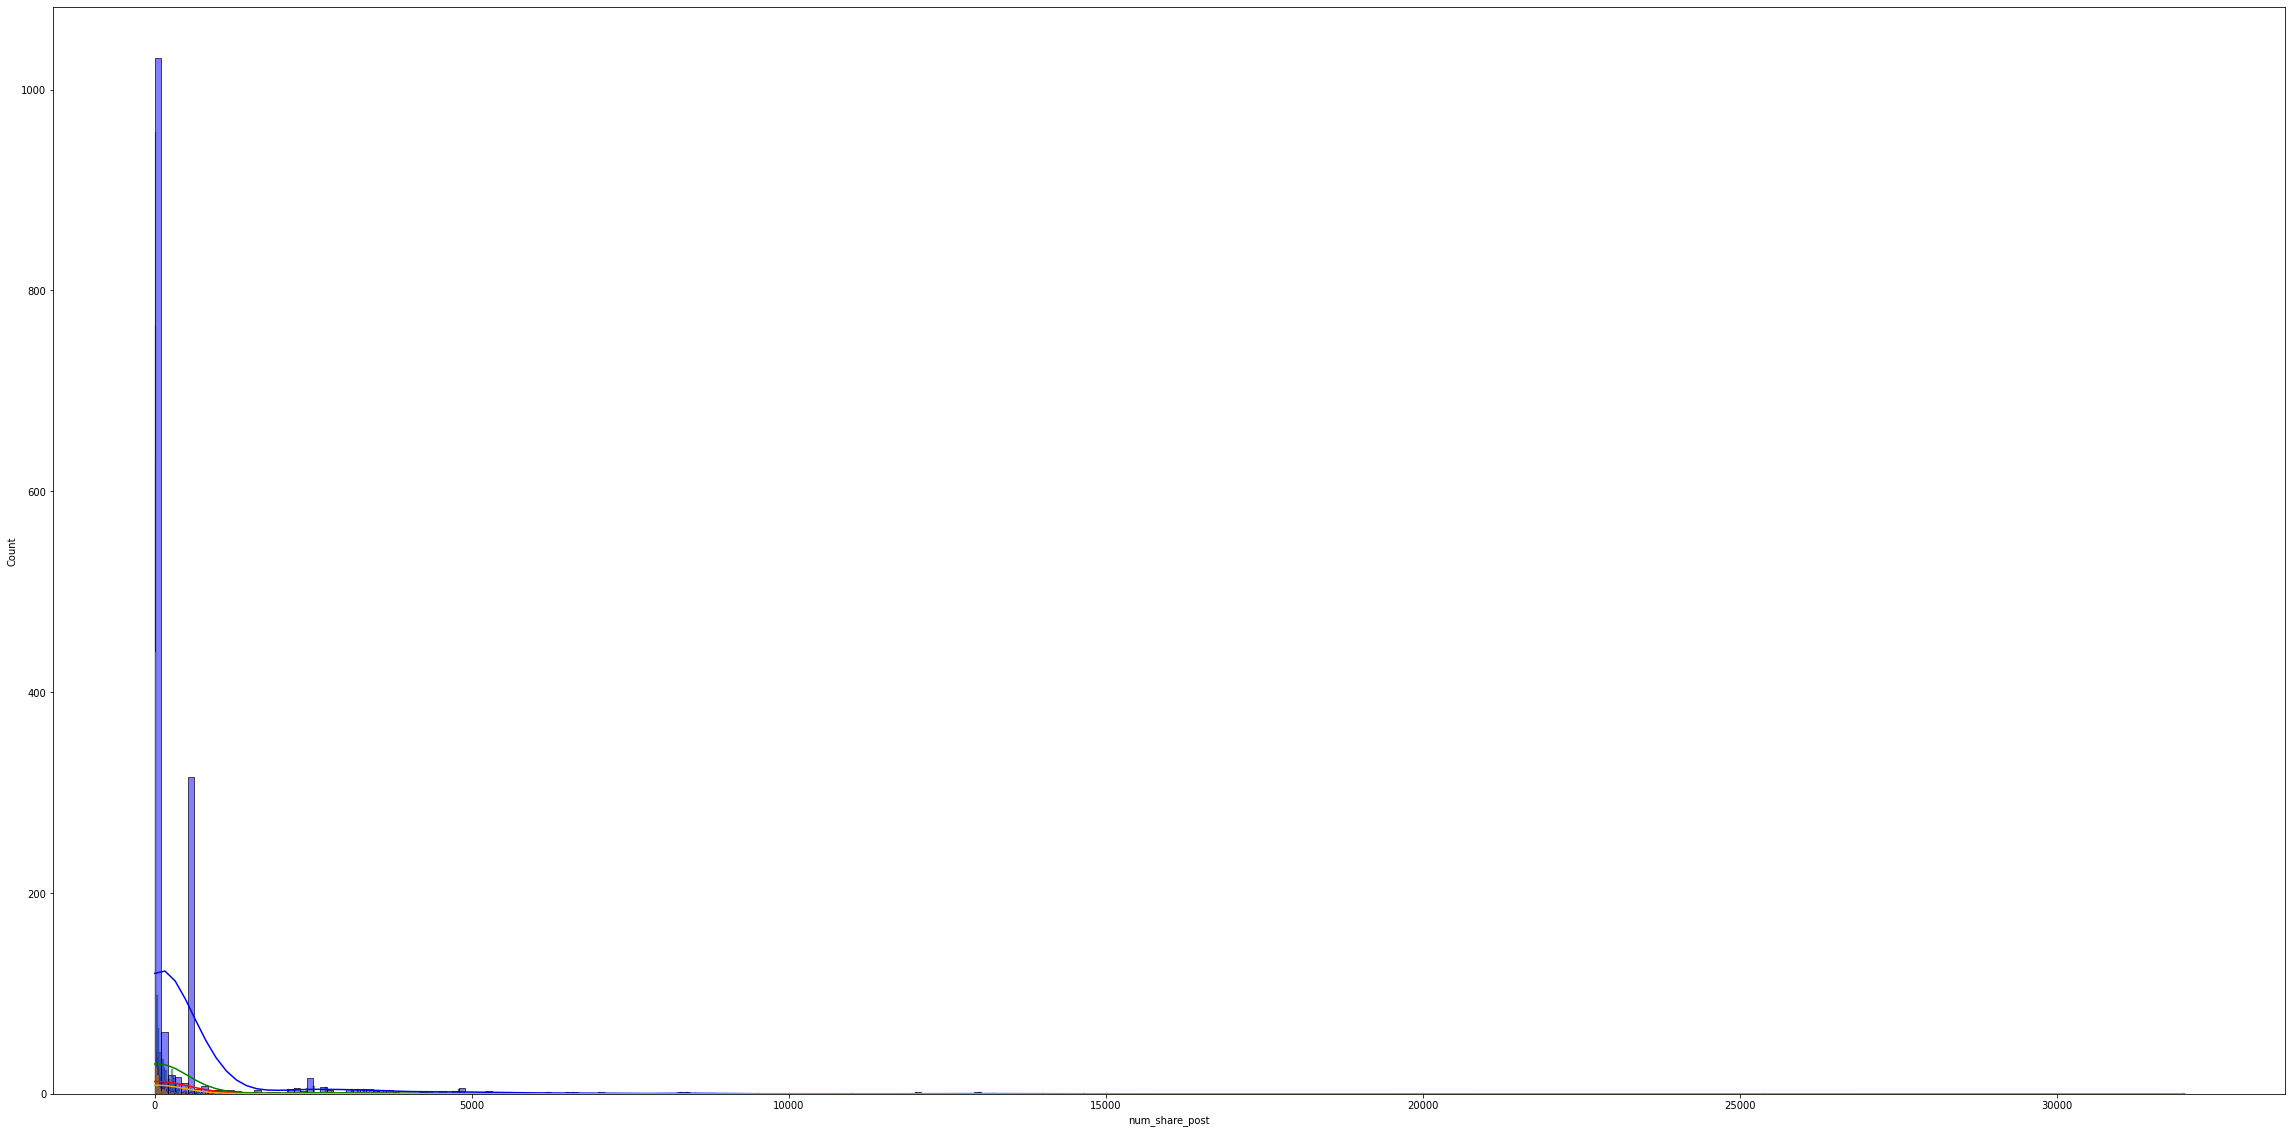

In [ ]:
fig = plt.figure(figsize=(40,20))
sns.histplot(data=df_test,x='num_share_post',kde=True,color='red')
sns.histplot(test1[:,3],kde=True,color='green')
sns.histplot(df_test['num_share_post'].fillna(df_test['num_share_post'].mean()),kde=True,color='blue')
sns.histplot(df_test['num_share_post'].fillna(df_test['num_share_post'].median()),kde=True,color='orange')

In [ ]:
#Fill median
df_train['num_share_post'] = df_train['num_share_post'].fillna(df_train['num_share_post'].median())

In [ ]:
df_test['num_share_post'] = df_test['num_share_post'].fillna(df_test['num_share_post'].median())

In [ ]:
df_pri['num_share_post'] = df_pri['num_share_post'].fillna(df_pri['num_share_post'].median())

# Creating feature

In [ ]:
def count_punc(sent,punc):
  cnt = 0
  for s in sent:
    if s==punc:
      cnt+=1
  return cnt

share_fake_cnt = {}
share_nonfake_cnt = {}
def create_features(data, fake_cnt=1):
  data['count_chars'] = data['post_message'].str.len()
  data['count_words'] = data['post_message'].str.split().map(lambda x: len(x))
  data['count_questionmark'] = data['post_message'].apply(lambda x: count_punc(x,'?'))
  data['count_exclaimmark'] = data['post_message'].apply(lambda x: count_punc(x,'!'))
  data['numHashtags'] = data['post_message'].apply(lambda x: len(re.findall(r'#(\w+)',x)))
  data['numUrls'] = data['post_message'].apply(lambda x: len(re.findall(r'<url>',x)))
    
  #filter from created_at
  data['post_month'] = pd.to_datetime(data['timestamp_post'], unit='s').dt.month
  data['post_year'] = pd.to_datetime(data['timestamp_post'], unit='s').dt.year
  data['post_day'] = pd.to_datetime(data['timestamp_post'], unit='s').dt.day
  data['post_hour'] = pd.to_datetime(data['timestamp_post'], unit='s').dt.hour
  data['post_weekday'] = pd.to_datetime(data['timestamp_post'], unit='s').dt.weekday

  #count share unreliable news ratio
  if fake_cnt == 1:
    for i in range(len(data['post_message'])):
      user = data['user_name'][i]
      share_fake_cnt[user] = 0
      share_nonfake_cnt[user] = 0

    for i in range(len(data['post_message'])):
      user = data['user_name'][i]
      label = data['label'][i]
      if label == 1:
          share_fake_cnt[user] += 1
      else:
          share_nonfake_cnt[user] += 1
      
  data['cnt_fake'] = data['num_comment_post']
  data['cnt_nonfake'] = data['num_comment_post']
  data['ratio'] = data['num_comment_post']
  for i in range(len(data['post_message'])):
    user = data['user_name'][i]
    try:
      fake_cnt = share_fake_cnt[user]
    except:
      fake_cnt = 0
    try:
      non_fake_cnt = share_nonfake_cnt[user]
    except:
      non_fake_cnt = 0
    data['cnt_fake'][i] = fake_cnt
    data['cnt_nonfake'][i] = non_fake_cnt
    data['ratio'][i] = fake_cnt / (fake_cnt + non_fake_cnt + 1e-9)



In [ ]:
create_features(df_train)
create_features(df_pri,fake_cnt=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Split into train/dev

In [ ]:
train, dev = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train['label'])

In [ ]:
def check_images(df, inputPath):
	# loop over the indexes of the houses
  for i in tqdm.tqdm(df.id.values):
    basePath = os.path.sep.join([inputPath, "{0}/*".format(i)])
    housePaths = sorted(list(glob.glob(basePath)))
    if len(housePaths)>0:
      df['has_image']=1
    else:
      df['has_image']=0


In [ ]:
import os
import glob

imagePath_final  = '/content/drive/MyDrive/vlsp2020/private_test_final_images'
imagePath_train  = '/content/drive/MyDrive/vlsp2020/public_train_final_images'
dev['has_image'] = 0
df_pri['has_image'] = 0

train_img = []
for i in tqdm.tqdm(train.id.values):
  basePath = os.path.sep.join([imagePath_train, "{0}/*".format(i)])
  housePaths = sorted(list(glob.glob(basePath)))
  if len(housePaths)>0:
    train_img.append(1)
  else:
    train_img.append(0)
train['has_image'] = train_img

dev_img = []
for i in tqdm.tqdm(dev.id.values):
  basePath = os.path.sep.join([imagePath_train, "{0}/*".format(i)])
  housePaths = sorted(list(glob.glob(basePath)))
  if len(housePaths)>0:
    dev_img.append(1)
  else:
    dev_img.append(0)
dev['has_image'] = dev_img

final_img = []
for i in tqdm.tqdm(df_pri.id.values):
  basePath = os.path.sep.join([imagePath_final, "{0}/*".format(i)])
  housePaths = sorted(list(glob.glob(basePath)))
  if len(housePaths)>0:
    final_img.append(1)
  else:
    final_img.append(0)
df_pri['has_image'] = final_img

In [ ]:
train.to_csv('/content/drive/My Drive/vlsp2020/train_rev1_news.csv',index=False)
dev.to_csv('/content/drive/My Drive/vlsp2020/dev_rev1_news.csv',index=False)
# df_test.to_csv('/content/drive/My Drive/vlsp2020/test_rev1_punc.csv',index=False)


In [ ]:
df_pri.to_csv('/content/drive/My Drive/vlsp2020/final_news.csv',index=False)


# Reading Image

In [ ]:
import glob
import cv2
import os
import random
import tqdm
import numpy as np
import pandas as pd

In [ ]:
imagePath_final  = '/content/drive/MyDrive/vlsp2020/private_test_final_images'

In [ ]:
imagePath_train  = '/content/drive/MyDrive/vlsp2020/public_train_final_images'

In [ ]:
# imagePath_test  = '/content/drive/MyDrive/vlsp2020/public_test_final_images'

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/vlsp2020/train_rev1.csv')
df_val = pd.read_csv('/content/drive/MyDrive/vlsp2020/dev_rev1.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/vlsp2020/test_rev1.csv')
df_pri = pd.read_csv('/content/drive/MyDrive/vlsp2020/final.csv')


In [ ]:
def load_images(df, inputPath):
  images = []
	# loop over the indexes of the houses
  for i in tqdm.tqdm(df.id.values):
    basePath = os.path.sep.join([inputPath, "{0}/*".format(i)])
    housePaths = sorted(list(glob.glob(basePath)))
    if len(housePaths)>0:
      try:
        inputImage = cv2.imread(random.choice(housePaths))
        inputImage = cv2.resize(inputImage, (299, 299))
      except:
        inputImage = np.zeros((299, 299, 3), dtype="uint8")
    else:
      inputImage = np.zeros((299, 299, 3), dtype="uint8")

    images.append(inputImage)
	# return our set of images
  return np.array(images)

In [ ]:
final_image = load_images(df_pri, imagePath_final)

100%|██████████| 1646/1646 [00:33<00:00, 49.31it/s] 


In [ ]:
train_image = load_images(df_train, imagePath_train)

100%|██████████| 3933/3933 [01:13<00:00, 53.76it/s]


In [ ]:
val_image = load_images(df_val, imagePath_train)

100%|██████████| 438/438 [00:09<00:00, 46.06it/s]


In [ ]:
# test_image = load_images(df_test, imagePath_test)

In [ ]:
np.save('/content/drive/MyDrive/vlsp2020/final-image-299.npy',final_image)

In [ ]:
np.save('/content/drive/MyDrive/vlsp2020/train-image-299.npy',train_image)
np.save('/content/drive/MyDrive/vlsp2020/val-image-299.npy',val_image)
#np.save('/content/drive/MyDrive/vlsp2020/test-image-224.npy',test_image)